<a href="https://colab.research.google.com/github/digwit678/Can-Language-Models-Follow-Discussions/blob/main/probing_sw9_reworked_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

# Structure of scraped discussions

`dumped_discussions_first.pickle` includes a 17.832 discussions. Every discussion entry looks as follows:

````
{
   "title": ... // Title of the kialo discussion
   "background info": ... // Background information of the kialo discussion
   "discussion": {
      "claims": [...] // All claims of the full discssion, more details later
      "locations": [...] // Location of the claims, more details later
      "touchedClaimOrLocationIds": // not relevant
   }
}
````

## Structure of claims
Every claim entry of a discussion has the following structure:
````
{
   "id": xxxx.yy // id of the claim it-self where xxxx is the discussion id, when yy is equal to 0 it is the root claim
   "authorId": "0077c272-1fdc-4202-a06a-160482dfc12d",
   "created": 1382962412430,
   "version": 2,
   "text": "Anonymous currency discussions", // text of the claim, often empty or not relevant for root claim (i.e. 333.0)
   "lastModifiedForSitemaps": 1382962412430
}
````
## Structure of positions
There is a location entry for every claim which is not the root claim. This entry describes the position of the claim and therefore its target.
````
{
   "id":"333.1228", // id of the relation
   "targetId":"333.355", // id of the source claim
   "version":1,
   "isOrigin":true,
   "authorIdentityId":"54d22c9853057c01262a7192",
   "created":1395770583629,
   "parentId":"333.338", // id of the target claim
   "relation":1, // 1 if relation is Pro, -1 if relation is Con
   "isDeleted":false, // ignore if it is true
   "lastModifiedForSitemaps":1520166022299
}
````

---



**Observation**: The same node (see 333.1) is being saved n times, whereas n = number of outgoing edges

General ID-Structure: [DiscussionID . ClaimID], claim_ids are not always in chronological order (so it not always follows 0.2 on 0.1)
Some ID´s are also skipped / missing / deleted


Nodes and edges being saved in igraph-sequences

In [ ]:
for i, node in enumerate(example_graph_nodes):
  if i < 10:
    print("source: ", node["name"]["id"])
    print("target: ", example_graph_edges[i].target_vertex["name"]["id"])
    print("-----------------------------------")



source:  333.0
target:  333.2
-----------------------------------
source:  333.1
target:  333.3
-----------------------------------
source:  333.2
target:  333.7
-----------------------------------
source:  333.3
target:  333.12
-----------------------------------
source:  333.4
target:  333.17
-----------------------------------
source:  333.5
target:  333.18
-----------------------------------
source:  333.7
target:  333.19
-----------------------------------
source:  333.9
target:  333.2
-----------------------------------
source:  333.1
target:  333.21
-----------------------------------
source:  333.11
target:  333.22
-----------------------------------


In [ ]:
 # local path
#pickle_file_path = "../../../data_preparation/kialo_data/3_parsed_node_data/parsed_discussion_graphs.pickle"
#with open(pickle_file_path, 'rb') as f:
   # parsed_discussion_graphs = pickle.load(f)

In [ ]:
#!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.2 MB/s eta 0:00:00


In [1]:
import random
from random import shuffle
from typing import List, Tuple, Set, Optional
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from math import ceil
from itertools import combinations
import pandas as pd
from pandas import DataFrame
pd.options.display.max_colwidth = 900
from sklearn.model_selection import train_test_split
import pickle
#import igraph as ig
import yaml
import os
import re
import ast
random.seed(42)

In [2]:
from google.colab import drive
base_path_gdrive = "/content/drive/MyDrive/Can Language Models Follow Discussions?/"
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load(name , probing_task_nr, file_type="pkl"):
  """
  - name (string):  file name or path without "/"
  - probing_task_nr [optional ](integer): probing task folder number or None
  - file_type (string): "pkl" default else specify

  """
  base_path_gdrive = r"/content/drive/MyDrive/Can Language Models Follow Discussions?/"
  # path = base_path_gdrive + f"probing_files/probe-{probing_task_nr}_" + name + "." + file_type
  if probing_task_nr == "" or probing_task_nr == None :
    path = base_path_gdrive  + name + "." + file_type
  else :
    path = base_path_gdrive + str(probing_task_nr) + "/" + name + "." + file_type
  if file_type == "pkl":
    with open (path , 'rb') as f:
        file_out =  pickle.load(f)
  else:
        file_out = pd.read_csv(path)
  print(path, "loaded.")

  return file_out

In [4]:
node_df = load("node_attributes_v7", 2, file_type="pkl")

/content/drive/MyDrive/Can Language Models Follow Discussions?/2/node_attributes_v7.pkl loaded.


In [5]:
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, are beneficial for the world.","[333.338, 333.168, 333.644, 333.69, 333.794, 333.832, 333.842, 333.1055, 333.1089, 333.169, 333.1696]","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 333.1111, 333.112]","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on top of them open doors for technological innovation.,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than cash.,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


In [ ]:
node_df

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.000,0,0,NaN,333.000,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.000,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.000,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.000,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.000,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
241654,241654,11336,46614.171,1,76,46614.300,46614.101,Shoud uniforms be required?,JAJAJAJAJAJAJAJAJAJAJAJAJAAJJAJAJAJAAJAJJAJAJA...,[],[],0.000000
241655,241655,11336,46614.173,1,77,46614.300,46614.101,Shoud uniforms be required?,WKGYEFUgfwdfiwudfysdgfygdsuagkdfgshfgsdjfkjdsg...,[],[],0.000000
241656,241656,11336,46614.170,2,0,46614.500,46614.101,Shoud uniforms be required?,I don't like the uniforms because I prefer to ...,[],[],0.000000
241657,241657,11336,46614.450,2,1,46614.230,46614.101,Shoud uniforms be required?,"Bulliying is not because our style, it's becau...",[],[],0.000000


In [ ]:
STOP

NameError: ignored

# Utility Functions

In [ ]:
def split_into_folds(df, num_folds=4):
    """
    Accepts dataframe without set columns and generates specified number of folds,
    where each claim appears in the test set only once
    """
    # Initialize set columns
    for i in range(num_folds):
        col_name = f'set-{i}'
        df[col_name] = None

    # Number of rows in the DataFrame
    num_rows = len(df)

    # Assign each row to a test set exactly once
    for i in range(num_folds):
        test_indices = range(i, num_rows, num_folds)
        df.loc[test_indices, f'set-{i}'] = 'test'

    # Assign each row to a dev set exactly once
    # Start the dev set one position shifted from the test set
    for i in range(num_folds):
        dev_indices = range((i + 1) % num_folds, num_rows, num_folds)
        df.loc[dev_indices, f'set-{i}'] = 'dev'

    # Fill the remaining with 'train'
    df.fillna('train', inplace=True)

    return df

# Sample DataFrame for testing
df_sample = pd.DataFrame({'Index': range(10), 'Graph_Index': range(10, 20)})
df_result = split_into_folds(df_sample)
print(df_result)


   Index  Graph_Index  set-0  set-1  set-2  set-3
0      0           10   test  train  train    dev
1      1           11    dev   test  train  train
2      2           12  train    dev   test  train
3      3           13  train  train    dev   test
4      4           14   test  train  train    dev
5      5           15    dev   test  train  train
6      6           16  train    dev   test  train
7      7           17  train  train    dev   test
8      8           18   test  train  train    dev
9      9           19    dev   test  train  train


In [ ]:
def save_all_folds_in_one(df_folds, probe_name, probe_number=None, base_path_gdrive="/content/drive/MyDrive/Can Language Models Follow Discussions?", num_folds=4):
    """
    Saves all the folds into a single DataFrame and returns it.
    """

    """
    Saves the YAML configuration file and DataFrame fold in the specified directory structure.

    Parameters:
    - fold: DataFrame containing the data for the probing task.
    - probe_name: Name of the probe.
    - probe_number: Number assigned to the probing task.
    - base_path_gdrive: The base path where the data should be saved.
    #- variation_name: Name of the variation folder if a variation exists.
    - num_folds: Number of folds for the probe. If set to 1, all data will be in a single fold.

    Notes:
    - The YAML file is saved only once per variation, not per fold.
    - The directory structure is created as needed: base directory -> variation directory -> set directory.
    - The function dynamically determines the number of unique labels in the DataFrame and adjusts the YAML configuration accordingly.
    """

    # Target column order
    target_columns = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0'] + [f'set-{i}' for i in range(1, num_folds)] + ['id', 'string_label', 'label']

    # Reorder the columns to match the target order
    final_df = df_folds[target_columns]

    print("After column alignment in save_all_folds_in_one: ", final_df.head())

    # Create directories if they don't exist
    base_dir = f"{base_path_gdrive}/{probe_number}"
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    # Saving Folds.csv
    final_df.to_csv(os.path.join(base_dir, "folds.csv"), index=False)


    # Generating YAML file
    num_labels = len(final_df['org_label'].unique()) # todo include regressoin case
    num_inputs = len(final_df['inputs'].iloc[0])
    #todo
    #task_types =["SENTENCE_PAIR_BI","SENTENCE"]
    #num_labels = 2
    #label_terminology = {1: "", 2: "bi", 3: "tri", 4: "tetra", 5: "penta", 6: "hexa", 7: "hepta", 8: "octa", 9: "ennea", 10: "deca", 11: "regression"}
    inputs_terminology = {1: "", 2: "-bi"}

    yaml_filename_none = f"config{inputs_terminology.get(num_inputs)}-none.yaml"
    yaml_filename_randomization = f"config{inputs_terminology.get(num_inputs)}-randomization.yaml"

    #if num_labels == 1
      # ==> regression
    if num_inputs == 1:
      probe_task_type = 'SENTENCE'
    else:
      probe_task_type = 'SENTENCE_PAIR_BI'

    config_none_content = {
        'control_task_type': 'NONE',
        'num_inputs': num_inputs,
        'num_labels': num_labels,
        'num_probe_folds': num_folds,
        'probe_name': f"probe_{probe_number}-{probe_name}",
        #'probe_task_type': f'SENTENCE_PAIR_{label_terminology.get(num_labels, "MULTI").upper()}',
        'probe_task_type':  probe_task_type ,
        'probes_samples_path': f'probing_files/probe_{probe_number}-{probe_name}'
    }

    config_randomization_content = {
        'control_task_type':'RANDOMIZATION',
        'num_inputs': num_inputs,
        'num_labels': num_labels,
        'num_probe_folds': num_folds,
        'probe_name': f"probe_{probe_number}-{probe_name}",
        #'probe_task_type': f'SENTENCE_PAIR_{label_terminology.get(num_labels, "MULTI").upper()}',
        'probe_task_type':  probe_task_type ,
        'probes_samples_path': f'probing_files/probe_{probe_number}-{probe_name}'
    }


    # Saving YAML files
    with open(os.path.join(base_dir, yaml_filename_none), 'w') as file:
        yaml.dump(config_none_content, file, default_flow_style=False)

    with open(os.path.join(base_dir, yaml_filename_randomization), 'w') as file:
        yaml.dump(config_randomization_content, file, default_flow_style=False)

    print(f"Saved data and YAML configurations in {base_dir}")

    return final_df


In [8]:
def save1(data, name, probing_task_nr=None, input_type="df", output_type="csv",probing_files=False):
    base_path = "/content/drive/MyDrive/Can Language Models Follow Discussions?/"  # Adjusted the path as internet access is disabled
    if probing_files == False:
      full_file_path = f"{base_path}{probing_task_nr}/{name}.{output_type}"
    else:
      full_file_path = f"{base_path}/probe_{probing_task_nr}-{name}/folds.{output_type}"


    if input_type == "df":
        if output_type == "csv":
            data.to_csv(full_file_path, index=False)
        elif output_type == "pkl":
            data.to_pickle(full_file_path)

    elif input_type == "list":
        if output_type == "csv":
            # Assuming that the list contains tuples with the same structure for all elements
            df = pd.DataFrame(data)
            df.to_csv(full_file_path, index=False)
        elif output_type == "pkl":
            with open(full_file_path, 'wb') as f:
                pickle.dump(data, f)

    elif input_type == "dict":
        if output_type == "pkl":
            with open(full_file_path, 'wb') as f:
                pickle.dump(data, f)

    print(f"File saved as {full_file_path}")

# Test the function with a sample DataFrame and list
#sample_df = pd.DataFrame({'col1': [1, 2, 3], 'col2': ['a', 'b', 'c']})
#sample_list = [(1, 'a'), (2, 'b'), (3, 'c')]

# Uncomment the following lines to actually save the files.
# They are commented to prevent file-writing in this example environment.
# save(sample_df, "sample_df", "Probing_Task_4", input_type="df", output_type="csv")
# save(sample_list, "sample_list", "Probing_Task_4", input_type="list", output_type="csv")

# Assuming 'examples' contains your list of generated data
#save(examples, "generated_examples", "Probing_Task_4", input_type="list", output_type="csv")


In [ ]:
def save(df, name, probing_task_nr, input_type = "df", output_type = "csv"):
  base_path_gdrive= "/content/drive/MyDrive/Can Language Models Follow Discussions?/"
  full_file_path = base_path_gdrive + f"{probing_task_nr}/{name}.{output_type}"
  if input_type == "df":
    if output_type == "csv":
          df.to_csv(full_file_path)
          #print(f"{name}.{output_type} saved to {base_path_gdrive}{probing_task_nr}/")
    if output_type == "pkl":
          df.to_pickle(full_file_path)
  if input_type == "dc":
    if output_type == "pkl":
        with open(full_file_path, 'wb') as f:
          pickle.dump(full_file_path, f)
  print(f'File saved as {full_file_path}')

In [25]:
def check_input_format(df):
  """
  Method to verify the input formats to be compatible with the probing framework
  """
  compatible_input_format = True
  for index, row in df.iterrows():
      try:
          # Attempt to evaluate the formatted string to see if it's a valid tuple
          eval(row['inputs'])
          # Uncomment the following line if you want to print confirmation for each row
          # print(f"Row {index} is correctly formatted as a tuple.")
      except Exception as e:
          # Output the problematic string and the error
          print(f"Error evaluating row {index} as a tuple: {row['inputs']}")
          print(f"Exception: {e}")
          compatible_input_format = False
  if compatible_input_format == True:
    print("All input formats are compatible with the probing framework.")
  return compatible_input_format

In [ ]:
# Function to calculate max depth from the base claim
def calculate_max_depth(graph, base_claim_index=0):
    return max([len(path) for path in graph.get_all_shortest_paths(base_claim_index)])

In [ ]:
def append_topic_to_first_claim(inputs_tuple):
    # Extracting the first and second claims

    first_claim, second_claim = inputs_tuple

    # Appending the topic to the first claim
    new_first_claim = f"{inputs_tuple}. {first_claim}"

    # Creating a new tuple with the modified first claim
    new_input = new_first_claim, second_claim

    return new_input

In [ ]:
def print_first_n_entries(dictionary, n, max_inner_items=5):
    """
    Print the first 'n' entries of a nested dictionary, showing only the first 'max_inner_items' key-value pairs of the inner dictionary at each depth level.

    Args:
        dictionary (dict): The nested dictionary to print.
        n (int): The number of entries to print.
        max_inner_items (int): The maximum number of key-value pairs to print from the inner dictionary at each depth level.

    Returns:
        None
    """
    def print_nested_dict(d, depth):
        if depth >= max_depth:
            return

        for key, value in d.items():
            if len(entries) >= n:
                return

            entries.append((key, value))
            print(f"Entry {len(entries)}:")
            print(f"Key: {key}")
            print("Value:")

            if isinstance(value, dict):
                sub_dict = {k: value[k] for k in list(value)[:max_inner_items]}
                print_nested_dict(sub_dict, depth + 1)
            else:
                print(f"  {value}\n")

    max_depth = max_inner_items
    entries = []

    print_nested_dict(dictionary, 0)



# Probing 1: Affirming / Opposing Claims ?

## v2 (Reworked) (hard version)

In [ ]:
# Initialize random seed for reproducibility
random.seed(42)

def random_walk(start_row, target_depth, claim_sequence, stance_sequence, current_stance, discussion):
    next_claim_row = start_row
    for depth in range(1, target_depth + 1):
        if not next_claim_row['Relations_To_Outgoing']:
            continue
        # Skip the base claim, which has a stance of 0, in the random walk.
        #print(next_claim_row['Relations_To_Outgoing'][0])
        if next_claim_row['Relations_To_Outgoing'][0] == 0:
            continue

        claim_sequence.append(next_claim_row['Node_ID'])
        stance_sequence.append(current_stance)

        directly_responding_claims = next_claim_row['Outgoing_Node_IDs']
        stances = next_claim_row['Relations_To_Outgoing']

        min_length = min(len(directly_responding_claims), len(stances))
        if min_length == 0:
            break

        choice_idx = random.choice(range(min_length))
        chosen_claim = directly_responding_claims[choice_idx]
        chosen_stance = stances[choice_idx]

        current_stance *= chosen_stance
        next_claim_candidates = discussion[discussion['Node_ID'] == chosen_claim]
        if next_claim_candidates.empty:
            break

        next_claim_row = next_claim_candidates.iloc[0]
    return current_stance, next_claim_row

def generate_stance_data(node_df, max_examples=200000):
    """
    Generates stance pairs by performing two random walks through each discussion.

    Parameters:
        node_df (pd.DataFrame): DataFrame containing node attributes.
        max_examples (int): Maximum number of examples to generate.

    Returns:
        pd.DataFrame: DataFrame containing stance pairs.
    """
    stance_pairs = []
    unique_pairs = set()
    max_trials = 100

    grouped_by_discussion = node_df.groupby('Graph_Index')

    with tqdm(total=grouped_by_discussion.ngroups, desc="Processing Discussions") as pbar_outer:
                for discussion_id, discussion in grouped_by_discussion:
                    pbar_outer.update(1)

                    if len(discussion) < 3:
                        continue

                    base_claim_candidates = discussion[discussion['Depth'] == 0]
                    if not base_claim_candidates.empty:
                        starting_claim_row = base_claim_candidates.iloc[0]
                    else:
                        continue

                    max_depth = discussion['Depth'].max()
                    trial_count = 0
                    #with tqdm(total=max_trials, desc=f"Processing Claims in Discussion {discussion_id}") as pbar_inner:
                    while trial_count < max_trials and len(stance_pairs) < max_examples:
                        trial_count += 1
                        #pbar_inner.update(1)

                        claim_sequence1, stance_sequence1 = [], []
                        current_stance1 = 1

                        target_depth1 = random.randint(1, max_depth)
                        current_stance1, last_claim1 = random_walk(starting_claim_row, target_depth1, claim_sequence1, stance_sequence1, current_stance1, discussion)

                        claim_sequence2, stance_sequence2 = [], []
                        current_stance2 = 1

                        target_depth2 = random.randint(1, max_depth)
                        current_stance2, last_claim2 = random_walk(starting_claim_row, target_depth2, claim_sequence2, stance_sequence2, current_stance2, discussion)

                        final_stance = current_stance1 * current_stance2

                        pair = (last_claim1['Claim_Text'], last_claim2['Claim_Text'])
                        if pair not in unique_pairs and pair[0] != pair[1]:
                            unique_pairs.add(pair)
                            stance_pairs.append((pair[0], pair[1], starting_claim_row['Base_Claim_Text'], final_stance, "Confirming" if final_stance == 1 else "Opposing"))

                        if trial_count == max_trials:
                            break

    return pd.DataFrame(stance_pairs, columns=['claim1', 'claim2', 'topic', 'relation', 'org_label'])

# Assume node_df is the DataFrame containing the discussion nodes
# stance_pairs_df = generate_stance_data(node_df)


In [ ]:
# Run data generation
stance_pairs_df_3 = generate_stance_data(node_df)
stance_pairs_df_3

Processing Discussions: 100%|██████████| 7838/7838 [08:04<00:00, 16.16it/s]


,claim1,claim2,topic,relation,org_label
0,"With AKMs in action, wars, conflicts or interf...",Military missions are often prevented by legal...,The West should build working autonomous killi...,1,Confirming
1,"Missions, which cannot be sold to the public b...","More than 3,000 AI experts signed a [2015 open...",The West should build working autonomous killi...,-1,Opposing
2,An AKM may be programmed with highly restricti...,"4,000 lives equal the loss of lives of the com...",The West should build working autonomous killi...,1,Confirming
3,Wars using AKMs would lead to dramatically red...,AKMs - just like cyber weapons - can potential...,The West should build working autonomous killi...,-1,Opposing
4,The adoption of new military technologies requ...,More conflict is not worse if it's accompanied...,The West should build working autonomous killi...,1,Confirming
...,...,...,...,...,...
175492,Uniforms are a safe way to see the children we...,"No, but if the uniform of the school are footb...",Shoud uniforms be required?,1,Confirming
175493,"I think that they are really uncomfortable, we...",I think is good because I don't need to dirty ...,Shoud uniforms be required?,-1,Opposing
175494,"Even tho uniforms are annoying, there are good...",Delen like y seran presidentes XD,Shoud uniforms be required?,-1,Opposing
175495,WKGYEFUgfwdfiwudfysdgfygdsuagkdfgshfgsdjfkjdsg...,"No, because I don't like the clothes of the sc...",Shoud uniforms be required?,1,Confirming


In [ ]:
def main_function_1(node_df, probe_name=None, probe_number=None):

    # Step 1: Generate claim pairs DataFrame
    claim_pairs_df = generate_stance_data(node_df) #DONE
    #claim_pairs_df = node_df

    # Step 2: Reset index for proper alignment (TODO: Verify)
    claim_pairs_df.reset_index(drop=True, inplace=True)

    # Step 3: Split into 4 folds (k-fold)
    claim_pairs_split_df = split_into_folds(claim_pairs_df)  # Assuming this function exists as in main_function_2

    # Step 4: Initialize DataFrame with target columns
    columns_target = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_target)

    # Step 5: Fill in the DataFrame with generated data
    final_df['index'] = claim_pairs_split_df.index + 1
    final_df['id'] = final_df['index']
    final_df['inputs'] = claim_pairs_split_df.apply(lambda row: (row['claim1'], row['claim2']), axis=1)
    final_df['context'] = np.nan  # No context for this task
    final_df['topic'] = claim_pairs_split_df['topic']
    final_df['org_label'] = claim_pairs_split_df['org_label']
    final_df['string_label'] = claim_pairs_split_df['org_label']
    final_df['label'] = [1 if claim_pairs_split_df['relation'] == 1 else 0]

    # Step 6: Transfer the set columns
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = claim_pairs_split_df[set_column]

    # Step 7: Save the DataFrame
    final_df = save_all_folds_in_one(final_df, probe_name=probe_name, probe_number=probe_number)
    print("Data processing and saving complete.")

    return final_df


In [ ]:
main_function_1(stance_pairs_df_3,"affirming_claims_v2" , 1)

After column alignment in save_all_folds_in_one:     index                                             inputs  context  \
0      1  (With AKMs in action, wars, conflicts or inter...      NaN   
1      2  (Missions, which cannot be sold to the public ...      NaN   
2      3  (An AKM may be programmed with highly restrict...      NaN   
3      4  (Wars using AKMs would lead to dramatically re...      NaN   
4      5  (The adoption of new military technologies req...      NaN   

                                               topic   org_label  set-0  \
0  The West should build working autonomous killi...  Confirming   test   
1  The West should build working autonomous killi...    Opposing    dev   
2  The West should build working autonomous killi...  Confirming  train   
3  The West should build working autonomous killi...    Opposing  train   
4  The West should build working autonomous killi...  Confirming   test   

   set-1  set-2  set-3  id string_label  label  
0  train  train  

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,"(With AKMs in action, wars, conflicts or inter...",NaN,The West should build working autonomous killi...,Confirming,test,train,train,dev,1,Confirming,1
1,2,"(Missions, which cannot be sold to the public ...",NaN,The West should build working autonomous killi...,Opposing,dev,test,train,train,2,Opposing,-1
2,3,(An AKM may be programmed with highly restrict...,NaN,The West should build working autonomous killi...,Confirming,train,dev,test,train,3,Confirming,1
3,4,(Wars using AKMs would lead to dramatically re...,NaN,The West should build working autonomous killi...,Opposing,train,train,dev,test,4,Opposing,-1
4,5,(The adoption of new military technologies req...,NaN,The West should build working autonomous killi...,Confirming,test,train,train,dev,5,Confirming,1
...,...,...,...,...,...,...,...,...,...,...,...,...
175492,175493,(Uniforms are a safe way to see the children w...,NaN,Shoud uniforms be required?,Confirming,test,train,train,dev,175493,Confirming,1
175493,175494,"(I think that they are really uncomfortable, w...",NaN,Shoud uniforms be required?,Opposing,dev,test,train,train,175494,Opposing,-1
175494,175495,"(Even tho uniforms are annoying, there are goo...",NaN,Shoud uniforms be required?,Opposing,train,dev,test,train,175495,Opposing,-1
175495,175496,(WKGYEFUgfwdfiwudfysdgfygdsuagkdfgshfgsdjfkjds...,NaN,Shoud uniforms be required?,Confirming,train,train,dev,test,175496,Confirming,1


In [ ]:
stop here

In [ ]:
filtered_df = node_df[node_df['Relations_To_Outgoing'].apply(lambda x: x == [1, 1])]
filtered_df

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
3,3,0,333.1680,2,1,333.167,333.000,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.0
62,62,0,333.1075,4,15,333.795,333.000,Anonymous currency discussions,Most users would have to hold accounts with mi...,"[333.1076, 333.1078]","[1, 1]",1.0
92,92,1,444.5080,1,11,444.100,444.100,There should be a 100% inheritance tax on all ...,People who become wealthy tend to invest and s...,"[444.514, 444.515]","[1, 1]",1.0
133,133,1,444.2400,3,78,444.170,444.100,There should be a 100% inheritance tax on all ...,Birth is not a lottery. Individuals are not pr...,"[444.244, 444.245]","[1, 1]",1.0
141,141,1,444.3650,2,48,444.520,444.100,There should be a 100% inheritance tax on all ...,Parents will be incentivized to spend all thei...,"[444.379, 444.38]","[1, 1]",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
241350,241350,11313,46395.3700,1,3,46395.000,46395.000,Which group is the media biased against?,Mexican people,"[46395.69, 46395.71]","[1, 1]",1.0
241351,241351,11313,46395.3900,1,4,46395.000,46395.000,Which group is the media biased against?,Asian people,"[46395.61, 46395.12]","[1, 1]",1.0
241362,241362,11313,46395.1240,2,10,46395.270,46395.000,Which group is the media biased against?,Media bias is a [subjective perception](https:...,"[46395.126, 46395.128]","[1, 1]",1.0
241416,241416,11322,46431.6600,2,10,46431.900,46431.101,There should be an internet government,The internet is based on the idea of the free ...,"[46431.113, 46431.176]","[1, 1]",1.0


In [ ]:
stance_pairs_df.head()

,claim1,claim2,topic,relation,org_label
0,"Cryptocurrencies, such as Bitcoin and others, ...","Not all cryptocurrencies require mining, or la...",Anonymous currency discussions,0,Opposing
1,Terrorism threat was able to elevate public su...,Counter-insurgency strategies that engage the ...,The West should build working autonomous killi...,-1,Opposing
2,The general public may not have sufficient sub...,The sensor identification ability of AKM techn...,The West should build working autonomous killi...,1,Confirming
3,Drafting and ratifying arms conventions is a l...,Opposition to the development and use of AKMs ...,The West should build working autonomous killi...,-1,Opposing
4,Because China has not yet conducted a successf...,Various countries - among them large ones such...,The West should build working autonomous killi...,1,Confirming


In [ ]:
stance_pairs_df

,claim1,claim2,topic,relation,org_label,set-0,set-1,set-2,set-3
0,"Cryptocurrencies, such as Bitcoin and others, ...","Not all cryptocurrencies require mining, or la...",Anonymous currency discussions,0,Opposing,test,train,train,dev
1,Terrorism threat was able to elevate public su...,Counter-insurgency strategies that engage the ...,The West should build working autonomous killi...,-1,Opposing,dev,test,train,train
2,The general public may not have sufficient sub...,The sensor identification ability of AKM techn...,The West should build working autonomous killi...,1,Confirming,train,dev,test,train
3,Drafting and ratifying arms conventions is a l...,Opposition to the development and use of AKMs ...,The West should build working autonomous killi...,-1,Opposing,train,train,dev,test
4,Because China has not yet conducted a successf...,Various countries - among them large ones such...,The West should build working autonomous killi...,1,Confirming,test,train,train,dev
...,...,...,...,...,...,...,...,...,...
99766,"No, because I don't like the clothes of the sc...",We also need to be free to decide what clothes...,Shoud uniforms be required?,1,Confirming,train,dev,test,train
99767,"I think that they are really uncomfortable, we...",I think is good because I don't need to dirty ...,Shoud uniforms be required?,-1,Opposing,train,train,dev,test
99768,I think that schools uniform shouldn't be requ...,[😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡...,Shoud uniforms be required?,1,Confirming,test,train,train,dev
99769,NO BECAUSE NO,I think uniforms shouldn't be required because...,Shoud uniforms be required?,-1,Opposing,dev,test,train,train


In [ ]:
stance_pairs_df.loc[stance_pairs_df["relation"].isnull()]

,claim1,claim2,topic,relation,org_label,set-0,set-1,set-2,set-3


In [ ]:
save(stance_pairs_df,"affirming_claims",1)

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/1/affirming_claims.csv


In [ ]:
claims_df=load("/1/affirming_claims")

In [ ]:
root_claim_df = node_df[node_df['Relations_To_Outgoing'].apply(lambda x: x == [0])]
root_claim_df

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.0,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.0
3787,3787,27,1258.0,0,0,NaN,1258.0,Are humans the only intelligent life form?,Are humans the only intelligent life form?,[1258.1],[0],0.0
14699,14699,136,2390.0,0,0,NaN,2390.0,A balance between ice and fire will bring abou...,A balance between ice and fire will bring abou...,[2390.4],[0],0.0
16204,16204,154,2435.0,0,0,NaN,2435.0,What is the identity of the [Knight of the Lau...,What is the identity of the [Knight of the Lau...,[2435.1],[0],0.0
19981,19981,190,2656.0,0,0,NaN,2656.0,Abortion/LGBTQ and America's Fall from Grace,Abortion/LGBTQ and America's Fall from Grace,[2656.1],[0],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
232395,232395,10763,41834.0,0,0,NaN,41834.0,lightweight BPM,lightweight BPM,[41834.3],[0],0.0
233965,233965,10877,42499.0,0,0,NaN,42499.0,There was no fraud or impropriety in the US 20...,There was no fraud or impropriety in the US 20...,[42499.95],[0],0.0
234846,234846,10930,42869.0,0,0,NaN,42869.0,Vedic Hinduism vs. other religions,Vedic Hinduism vs. other religions,[42869.3],[0],0.0
240684,240684,11251,45487.0,0,0,NaN,45487.0,Cryptoeconomics of UDAs and T-Addrs in Zcash,Cryptoeconomics of UDAs and T-Addrs in Zcash,[45487.13],[0],0.0


## v3 Only sequential claims (light version)

In [ ]:
import pandas as pd
from tqdm import tqdm

def generate_sequential_stance_data(node_df, desired_number_of_pairs_per_discussion):
    """
    Generates a balanced number of positive and negative sequential stance pairs per discussion.

    The function attempts to generate an equal number of positive and negative examples for each discussion,
    up to the specified number of desired pairs per discussion. If there aren't enough examples of one type,
    it fills the gap with the other type. If no pairs are left, it continues to the next discussion.

    Args:
        node_df (pd.DataFrame): DataFrame containing node information of discussions.
        desired_number_of_pairs_per_discussion (int): Desired number of pairs (both positive and negative) per discussion.

    Returns:
        pd.DataFrame: DataFrame containing generated pairs with claims, topic, relation, and original label.
    """
    final_pairs = []

    # Iterate over each unique base claim ID to process discussions individually
    base_claim_ids = node_df['Base_Claim_ID'].dropna().unique()

    for base_claim_id in tqdm(base_claim_ids, desc="Processing Discussions"):
        positive_examples = []
        negative_examples = []

        # Select all nodes related to the current base claim
        discussion_df = node_df[node_df['Base_Claim_ID'] == base_claim_id]

        # Generate examples for each node in the discussion
        for _, node in discussion_df.iterrows():
            outgoing_ids = node.get('Outgoing_Node_IDs', [])
            if not isinstance(outgoing_ids, list) or not outgoing_ids:
                continue

            for out_id in outgoing_ids:
                claim2_df = discussion_df[discussion_df['Node_ID'] == out_id]
                if claim2_df.empty:
                    continue

                # Determine relation and label
                relation_index = node['Outgoing_Node_IDs'].index(out_id)
                relation = node['Relations_To_Outgoing'][relation_index]
                label = "Affirming" if relation == 1 else "Opposing"

                example = {
                    'claim1': node['Claim_Text'],
                    'claim2': claim2_df.iloc[0]['Claim_Text'],
                    'topic': node['Base_Claim_Text'],
                    'relation': relation,
                    'org_label': label
                }

                # Collecting positive and negative examples separately
                if relation == 1 and len(positive_examples) < desired_number_of_pairs_per_discussion:
                    positive_examples.append(example)
                elif relation == -1 and len(negative_examples) < desired_number_of_pairs_per_discussion:
                    negative_examples.append(example)

        # Append examples to final list, aiming for a balance and moving to next discussion if necessary
        final_pairs.extend(positive_examples[:desired_number_of_pairs_per_discussion])
        final_pairs.extend(negative_examples[:desired_number_of_pairs_per_discussion])

    return pd.DataFrame(final_pairs, columns=['claim1', 'claim2', 'topic', 'relation', 'org_label'])

In [ ]:
def main_1_light(node_df_path, desired_number_of_pairs_per_discussion=20, probe_name="probe-1_affirming_opposing_light", probe_number=1):

    # Generate sequential stance data examples
    claim_pairs_df = generate_sequential_stance_data(node_df,desired_number_of_pairs_per_discussion)
    claim_pairs_df.reset_index(drop=True, inplace=True)
    # Step 3: Split into 4 folds (k-fold)
    claim_pairs_split_df = split_into_folds(claim_pairs_df)  # Assuming this function exists as in main_function_2
    # Step 4: Initialize DataFrame with target columns
    columns_target = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_target)
    # Step 5: Fill in the DataFrame with generated data
    final_df['index'] = claim_pairs_split_df.index + 1
    final_df['id'] = final_df['index']
    final_df['inputs'] =  claim_pairs_split_df.apply(lambda row: (row['claim1'], row['claim2']), axis=1)
    final_df['context'] = np.nan  # No context for this task
    final_df['topic'] = claim_pairs_split_df['topic']
    final_df['org_label'] = claim_pairs_split_df['org_label']
    final_df['string_label'] = claim_pairs_split_df['org_label']
    final_df['label'] = claim_pairs_split_df['relation'].apply(lambda x: 1 if x == 1 else 0)
    # Step 6: Transfer the set columns
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = claim_pairs_split_df[set_column]
    # Step 7: Save the DataFrame
    final_df = save_all_folds_in_one(final_df, probe_name=probe_name, probe_number=probe_number)
    print("Data processing and saving complete.")

    return final_df

In [ ]:
final_df = main_1_light(node_df)
final_df

Processing Discussions: 100%|██████████| 7407/7407 [02:07<00:00, 58.08it/s] 


After column alignment in save_all_folds_in_one:     index  \
0      1   
1      2   
2      3   
3      4   
4      5   

                                                                                                                                                                                                                                                                                                                                                                                                       inputs  \
0                                                                                                                                                                                                                          (Cryptocurrencies, such as Bitcoin and others, are beneficial for the world., Cryptocurrencies and the technologies built on top of them open doors for technological innovation.)   
1                                                                          

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,"(Cryptocurrencies, such as Bitcoin and others, are beneficial for the world., Cryptocurrencies and the technologies built on top of them open doors for technological innovation.)",NaN,Anonymous currency discussions,Affirming,test,train,train,dev,1,Affirming,1
1,2,"(Cryptocurrencies, such as Bitcoin and others, are beneficial for the world., A cryptocurrency is harder to counterfeit than cash.)",NaN,Anonymous currency discussions,Affirming,dev,test,train,train,2,Affirming,1
2,3,"(Cryptocurrencies, such as Bitcoin and others, are beneficial for the world., If there were a vote in civilized societies, whether the people want money laundering controls, whether they want to curb illegal activities by making the buying of aforementioned more difficult and whether they want to make tax evasion more difficult, the people would surely vote against anonymous cash transfers.)",NaN,Anonymous currency discussions,Affirming,train,dev,test,train,3,Affirming,1
3,4,"(Cryptocurrencies, such as Bitcoin and others, are beneficial for the world., Cryptocurrencies would make banking more accessible.)",NaN,Anonymous currency discussions,Affirming,train,train,dev,test,4,Affirming,1
4,5,"(Cryptocurrencies, such as Bitcoin and others, are beneficial for the world., Cryptocurrencies enhance privacy for market transactions.)",NaN,Anonymous currency discussions,Affirming,test,train,train,dev,5,Affirming,1
...,...,...,...,...,...,...,...,...,...,...,...,...
118107,118108,"(Shoud uniforms be required?, I would like to wear the clothes that I like)",NaN,Shoud uniforms be required?,Opposing,train,train,dev,test,118108,Opposing,0
118108,118109,"(Shoud uniforms be required?, I don't like it because is so bad for our bodies.)",NaN,Shoud uniforms be required?,Opposing,test,train,train,dev,118109,Opposing,0
118109,118110,"(Shoud uniforms be required?, They are bad because students can't make their own choice of what clothes they wish to wear to their school, and they need to wear the same clothes everyday, they can get tired and bored from this. It's also sometimes uncomfortable for some students.)",NaN,Shoud uniforms be required?,Opposing,dev,test,train,train,118110,Opposing,0
118110,118111,"(Shoud uniforms be required?, I THING THE UNIFORN IT BAD BECAUSE IF UNE SCHOOL DON'T HAVE DE OTHER NEET TO DON'T HAVE...)",NaN,Shoud uniforms be required?,Opposing,train,dev,test,train,118111,Opposing,0


# Probing 2: Immediate / Distant Claims ? / Sequential Claims

## Task Definition

The primary objective of this research is to determine ***whether language models have the capability to identify the sequential relationship between two claims within the same discussion***.

**Input:** Two claims originating from the same discussion.

**Output:** A binary label indicating if the second claim directly responds to the first claim.

## Variations and Considerations

### Multi-level Consecutiveness
This task could be expanded to not only identify if a claim is a direct response, but also to determine the number of levels separating the two claims from each other.

### Base Claim Context
Incorporating the base claim as context could either simplify or complicate the task, depending on the model's effectiveness in utilizing it.

In [ ]:
def generate_immediate_claims_data(discussion_df, max_examples=200000):

    """ v2

    Generates a balanced set of immediate and separate claim pairs from a DataFrame.

    Parameters:
        discussion_df (pd.DataFrame): DataFrame containing node attributes.
        max_examples (int): Maximum number of examples to generate.

    Returns:
        pd.DataFrame: A DataFrame containing as many balanced claim pairs as possible for the probing task.

    """
    immediate_claims = []
    separate_claims = []
    existing_pairs = set()

    # Group the DataFrame by discussion
    discussions = discussion_df.groupby('Graph_Index')

    for discussion_id, discussion in tqdm(discussions, desc='Processing Discussions ...'):
        # Loop through each claim in the discussion
        for idx, claim in discussion.iterrows():
            previous_claim_id = claim['Parent Node']
            current_claim_id = claim['Node_ID']
            base_claim_id = claim['Base_Claim_ID']

            # Identify immediate claims
            immediate_candidate = discussion[discussion['Node_ID'] == previous_claim_id]
            if not immediate_candidate.empty:
                immediate_pair = (immediate_candidate.iloc[0]['Claim_Text'], claim['Claim_Text'])
                if immediate_pair not in existing_pairs:
                    immediate_claims.append((immediate_pair[0], immediate_pair[1], base_claim_id, 'Immediate', 1))
                    existing_pairs.add(immediate_pair)

            # Identify separate claims
            separate_candidates = discussion[discussion['Node_ID'] != previous_claim_id]
            if not separate_candidates.empty:
                separate_candidate = separate_candidates.sample(1, replace=True)
                separate_pair = (separate_candidate.iloc[0]['Claim_Text'], claim['Claim_Text'])
                if separate_pair not in existing_pairs:
                    separate_claims.append((separate_pair[0], separate_pair[1], base_claim_id, 'Separate', 0))
                    existing_pairs.add(separate_pair)

            # Stop if max_examples reached
            if len(immediate_claims) + len(separate_claims) >= max_examples:
                break

        if len(immediate_claims) + len(separate_claims) >= max_examples:
            break

    # Create as many balanced examples as possible
    min_length = min(len(immediate_claims), len(separate_claims))
    immediate_claims = immediate_claims[:min_length]
    separate_claims = separate_claims[:min_length]

    # Combine and shuffle pairs
    all_claims = immediate_claims + separate_claims
    shuffle(all_claims)

    # Fill up with unbalanced examples if needed
    remaining_examples = max_examples - len(all_claims)
    extra_claims = immediate_claims if len(immediate_claims) > len(separate_claims) else separate_claims
    all_claims += extra_claims[:remaining_examples]
    #print("Verify number of generated claims: ", len(all_claims))
    # Convert to DataFrame
    claim_pairs_df = pd.DataFrame(all_claims, columns=['claim1', 'claim2', 'topic', 'org_label', 'label'])


    return claim_pairs_df


In [ ]:
def main_function_2(node_df, probe_name="immediate_claims", probe_number = 2):


    # Create claim pairs DataFrame
    claim_pairs_df = generate_immediate_claims_data(node_df)

    # Reset index for proper alignment
    claim_pairs_df = claim_pairs_df.reset_index(drop=True)

    # Split into 4 folds (k-fold)
    claim_pairs_split_df = split_into_folds(claim_pairs_df)

    # Initialize empty DataFrame with the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)

    # Fill in the DataFrame
    final_df['index'] = claim_pairs_split_df .index + 1
    final_df['id'] = final_df['index']
    final_df['inputs'] = claim_pairs_split_df .apply(lambda row: (row['claim1'], row['claim2']), axis=1)
    final_df['context'] = np.nan  # No context for this task
    final_df['topic'] = node_df.base_claim_text[claim_pairs_split_df ['topic']]
    final_df['org_label'] = claim_pairs_split_df ['org_label']
    final_df['string_label'] = claim_pairs_split_df ['org_label']
    final_df['label'] = claim_pairs_df['org_label'].map({'Immediate': 1, 'Separate': 0})

    # Transfer the set columns from claim_pairs_df to final_df
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = claim_pairs_split_df[set_column]

    # Save the DataFrame
    final_df = save_all_folds_in_one(final_df, probe_name = probe_name, probe_number = probe_number)

    print("Data processing and saving complete.")
    return final_df


In [ ]:
immediate_claims_df = main_function_2(node_df, probe_name = "immediate_claims")
immediate_claims_df.head()

Processing Discussions ...:  33%|███▎      | 2574/7838 [01:54<03:54, 22.41it/s]


After column alignment in save_all_folds_in_one:     index                                             inputs  context    topic  \
0      1  (The Catholic Church is the most prominent pro...      NaN   2851.1   
1      2  (Ontario should have only one public, secular ...      NaN  13901.1   
2      3  (No one is above the law or our US Constitutio...      NaN  12632.1   
3      4  (Veritaserum would constitute a severe violati...      NaN   2415.1   
4      5  (In a capitalist system, the interests of the ...      NaN   3252.1   

   org_label  set-0  set-1  set-2  set-3  id string_label  label  
0   Separate   test  train  train    dev   1     Separate      0  
1  Immediate    dev   test  train  train   2    Immediate      1  
2   Separate  train    dev   test  train   3     Separate      0  
3  Immediate  train  train    dev   test   4    Immediate      1  
4  Immediate   test  train  train    dev   5    Immediate      1  
Saved data and YAML configuration in /content/drive/MyDrive/C

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,(The Catholic Church is the most prominent pro...,NaN,2851.1,Separate,test,train,train,dev,1,Separate,0
1,2,"(Ontario should have only one public, secular ...",NaN,13901.1,Immediate,dev,test,train,train,2,Immediate,1
2,3,(No one is above the law or our US Constitutio...,NaN,12632.1,Separate,train,dev,test,train,3,Separate,0
3,4,(Veritaserum would constitute a severe violati...,NaN,2415.1,Immediate,train,train,dev,test,4,Immediate,1
4,5,"(In a capitalist system, the interests of the ...",NaN,3252.1,Immediate,test,train,train,dev,5,Immediate,1


In [ ]:
save(immediate_claims_df,  "immediate_claims_df", 2)

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/2/immediate_claims_df.csv


In [ ]:
immediate_claims_df = load("immediate_claims_df", 2)

In [ ]:
immediate_claims_df

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,(The Catholic Church is the most prominent pro...,NaN,2851.1,Separate,test,train,train,dev,1,Separate,0
1,2,"(Ontario should have only one public, secular ...",NaN,13901.1,Immediate,dev,test,train,train,2,Immediate,1
2,3,(No one is above the law or our US Constitutio...,NaN,12632.1,Separate,train,dev,test,train,3,Separate,0
3,4,(Veritaserum would constitute a severe violati...,NaN,2415.1,Immediate,train,train,dev,test,4,Immediate,1
4,5,"(In a capitalist system, the interests of the ...",NaN,3252.1,Immediate,test,train,train,dev,5,Immediate,1
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199996,"(Even though expected, the actual test gives m...",NaN,1108.1,Separate,train,train,dev,test,199996,Separate,0
199996,199997,(The Japanese army was completely taken by [su...,NaN,1108.1,Separate,test,train,train,dev,199997,Separate,0
199997,199998,(Individual soldiers can fight for as long as ...,NaN,1108.1,Separate,dev,test,train,train,199998,Separate,0
199998,199999,"(To definitively end a war, it is necessary fo...",NaN,1108.1,Separate,train,dev,test,train,199999,Separate,0


In [ ]:
final_df['topic'] = example_df['Claim1'].map(claim_to_base_claim) # Topic is the same as context

In [ ]:
seq_claims_df = load("probing_files/probe_2-sequential claims/folds","","csv")

/content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_2-sequential claims/folds.csv loaded.


In [ ]:
seq_claims_df.head()

,Unnamed: 0,inputs,context,topic,org_label,id,string_label,label,set-0
0,78762,('Children would feel more comfortable knowing...,NaN,29248.1,Consecutive,228248,1,1,train
1,65237,"('The ""scientific errors"" in the Quran have be...",NaN,30051.1,Consecutive,219452,1,1,train
2,148234,('Fashion has often been a core element of pro...,NaN,19160.1,Consecutive,411316,1,1,train
3,48141,('If this really would be the case the tournam...,NaN,1473.1,Consecutive,49313,1,1,train
4,215614,('Parents had a child because they thought it ...,NaN,16579.1,Non-Consecutive,152323,0,0,train


In [ ]:
immediate_claims_df = load("immediate_claims_df",2,"csv")

/content/drive/MyDrive/Can Language Models Follow Discussions?/2/immediate_claims_df.csv loaded.


In [ ]:
# Rename the relevant column in node_df for clarity
node_df.rename(columns={'Base_Claim_ID': 'topic', 'Base_Claim_Text': 'base_claim_text'}, inplace=True)

# Merge the dataframes on the 'topic' column
merged_df = pd.merge(immediate_claims_df, node_df, on='topic', how='left')

# The merged dataframe now contains the base claim text corresponding to each topic ID.

# Change the value of topic to base claim text instead of id
immediate_claims_df['topic'] = merged_df['base_claim_text']


In [ ]:
immediate_claims_df.head()

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,('The Catholic Church is the most prominent pr...,NaN,Conscientious objection to abortion should be ...,Separate,test,train,train,dev,1,Separate,0
1,2,"('Ontario should have only one public, secular...",NaN,Conscientious objection to abortion should be ...,Immediate,dev,test,train,train,2,Immediate,1
2,3,('No one is above the law or our US Constituti...,NaN,Conscientious objection to abortion should be ...,Separate,train,dev,test,train,3,Separate,0
3,4,"(""Veritaserum would constitute a severe violat...",NaN,Conscientious objection to abortion should be ...,Immediate,train,train,dev,test,4,Immediate,1
4,5,"('In a capitalist system, the interests of the...",NaN,Conscientious objection to abortion should be ...,Immediate,test,train,train,dev,5,Immediate,1


In [ ]:
save(immediate_claims_df,"immediate_claims_df",2 )

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/2/immediate_claims_df.csv


# Probing 3: Reactiveness

### Task Definition
The primary objective of this research task is to examine whether language models can predict the level of reactiveness (would this claim provoke many responses ?) and the type of stance (are the responses mostly affirming or opposing ?) a claim will evoke within a discussion.

### Input
- A claim from a discussion
- The title of the same discussion

### Output
- A score or label indicating how reactive the claim is, based on the `Normalized_Reactiveness_Score`.
- A label indicating the predominant type of stance the claim provokes (positive or negative) and its degree desribed in 3 discreet categories (weakly, moderately, strongly) determined by the thresholds within the distribution.

### Variations and Considerations

#### Multiple Discussion Contexts
To determine the level of reactiveness within one discussion the base claim should be appended

#### Variations / Difficulty Levels
- To increase difficulty, base claim can be removed from input or more detailed numbers can be asked for (how many claims ..?)

In [ ]:
# Loading node attributes
node_df = load("node_attributes_v5", 2)
#node_df.drop("Unnamed: 0", axis=1, inplace=True)

/content/drive/MyDrive/Can Language Models Follow Discussions?//2/node_attributes_v5.pkl loaded.


In [ ]:
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


In [ ]:
# Function to split data into multiple folds with training, validation, and test sets
def split_into_folds(df, num_folds=4):
    # Initialize columns for each set with 'None'
    for i in range(num_folds):
        df[f'set-{i}'] = None

    # Shuffle the DataFrame
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Divide the DataFrame into equal parts based on the number of folds
    fold_size = len(df) // num_folds

    # Create a mask to keep track of which rows are used as test in any fold
    used_as_test = np.zeros(len(df), dtype=bool)

    for i in range(num_folds):
        # Extract a portion of the DataFrame for the current fold
        # Ensuring that these have not been used as test before
        available_for_test = np.logical_not(used_as_test)
        test_mask = np.zeros(len(df), dtype=bool)
        test_mask[:fold_size] = True
        np.random.shuffle(test_mask)

        # Combine the mask to get the indices of the test set for this fold
        test_mask = np.logical_and(test_mask, available_for_test)

        # Mark these as used in test
        used_as_test = np.logical_or(used_as_test, test_mask)

        # Extract indices for train, dev, and test sets
        test_indices = np.where(test_mask)[0]
        train_dev_indices = np.where(np.logical_not(test_mask))[0]

        # Create train, dev, and test sets
        train_indices, dev_indices = train_test_split(train_dev_indices, test_size=0.2, random_state=42)

        # Update the 'set-{i}' column
        df.loc[train_indices, f'set-{i}'] = 'train'
        df.loc[dev_indices, f'set-{i}'] = 'dev'
        df.loc[test_indices, f'set-{i}'] = 'test'

    return df

# Create a sample DataFrame
sample_df = pd.DataFrame({
    'Claim_Text': [f'Sample {i}' for i in range(1, 21)],
})

# Call the function to split the sample data into 4 folds
result_df = split_into_folds(sample_df.copy())
result_df


,Claim_Text,set-0,set-1,set-2,set-3
0,Sample 1,dev,dev,dev,dev
1,Sample 2,train,dev,dev,dev
2,Sample 3,train,train,test,train
3,Sample 4,test,train,train,train
4,Sample 5,test,train,train,train
5,Sample 6,train,dev,train,dev
6,Sample 7,train,train,dev,train
7,Sample 8,test,train,train,train
8,Sample 9,train,train,train,dev
9,Sample 10,train,train,train,test


In [ ]:
# todo : document
def calculate_reactiveness(row):
    return len(row['Relations_To_Outgoing'])

def normalize_by_max_in_discussion(row, max_outgoing_per_discussion):
    max_outgoing = max_outgoing_per_discussion[row['Base_Claim_ID']]
    if max_outgoing == 0:
        return 0
    return len(row['Relations_To_Outgoing']) / max_outgoing

def normalize_by_max_global(row, max_outgoing_global):
    if max_outgoing_global == 0:
        return 0
    return len(row['Relations_To_Outgoing']) / max_outgoing_global

 # TODO CHANGE to _reactiveness distribution , not stance here anymore (clean code)
def calculate_stance_distribution(row):
    relations_str = row['Relations_To_Outgoing']
    if relations_str is None or pd.isna(relations_str):
        return {"positive": 0, "negative": 0}
    else:
        relations = np.array(ast.literal_eval(relations_str))
        positive_count = np.sum(relations == 1)
        negative_count = np.sum(relations == -1)
        return {"positive": positive_count, "negative": negative_count}


def create_combined_string_label(reactiveness_score, stance_distribution): #TODO REFORMAT/CHANGE VERTICALLY
    # todo remove/adjust label calculation according to dynamic creation
    reactiveness_label = "Strong" if reactiveness_score > 0.66 else "Moderate" if reactiveness_score > 0.33 else "Weak"
    stance_label = create_stance_string_label(stance_distribution)
    return f"{reactiveness_label} [Reactiveness], {stance_label}"


def create_stance_string_label(stance_distribution): #TODO REFORMAT/CHANGE VERTICALLY
    positive_ratio = stance_distribution["positive"] / (stance_distribution["positive"] + stance_distribution["negative"]) if stance_distribution["positive"] + stance_distribution["negative"] != 0 else 0
    return "Strongly Positive" if positive_ratio > 0.8 else "Positive" if positive_ratio > 0.6 else "Neutral" if positive_ratio >= 0.4 else "Strongly Negative" if positive_ratio < 0.2 else "Negative"



In [ ]:

def main_function_3(node_df, is_global = True, probe_name = ""):

    # Calculate Reactiveness and Stance Distribution
    node_df['Reactiveness_Score'] = node_df.apply(calculate_reactiveness, axis=1)
    node_df['Stance_Distribution'] = node_df.apply(calculate_stance_distribution, axis=1)


    # Create Combined String Label
    node_df['Combined_String_Label'] = node_df.apply(lambda row: create_combined_string_label(row['Reactiveness_Score'], row['Stance_Distribution']), axis=1)

    # Calculate maximum number of outgoing nodes for each discussion
    max_outgoing_per_discussion = node_df.groupby('Base_Claim_ID')['Relations_To_Outgoing'].apply(lambda x: max(len(ids) for ids in x))

    # Calculate the global maximum number of outgoing nodes across all discussions
    max_outgoing_global = max(max_outgoing_per_discussion)

    # Initialize Columns if they do not exist
    """
    if 'Normalized_Reactiveness_Score_Across' not in node_df.columns:
        node_df['Normalized_Reactiveness_Score_Across'] = 0.0
    if 'Normalized_Reactiveness_Score_Within' not in node_df.columns:
        node_df['Normalized_Reactiveness_Score_Within'] = 0.0
    """
    if is_global:
        node_df['Normalized_Reactiveness_Score_Across'] = node_df.apply(lambda row: normalize_by_max_global(row, max_outgoing_global), axis=1)
    else:
        node_df['Normalized_Reactiveness_Score_Within'] = node_df.apply(lambda row: normalize_by_max_in_discussion(row, max_outgoing_per_discussion), axis=1)

    # Reset index for proper alignment
    node_df = node_df.reset_index(drop=True)

    # Split the data into 4 folds with different test sets (k-fold)
    node_df = split_into_folds(node_df)
    print("after split:", node_df)
    # Initialize empty DataFrame with only the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)

    # Fill in the columns
    final_df['index'] = node_df.index + 1  # Index starting from 1
    final_df['id'] = final_df['index']  # 'id' is the same as 'index'
    final_df['inputs'] = node_df['Claim_Text']
    final_df['context'] = np.nan
    final_df['topic'] = node_df['Base_Claim_Text']
    final_df['org_label'] = node_df['Combined_String_Label']
    final_df['string_label'] = node_df['Combined_String_Label']
    final_df['label'] = node_df.apply(lambda row: (row['Reactiveness_Score'], row['Stance_Distribution']), axis=1)

    # Transfer the set-columns from node_df to final_df
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = node_df[set_column]

    print("Before saving:", final_df.head())
    # Save
    final_df = save_all_folds_in_one(final_df, probe_name,probe_number=3)

    print("Data processing and saving complete.")
    return final_df


In [ ]:
reactiveness_df = main_function_3(node_df, is_global = False, probe_name = "3_reactiveness_probe_1")
reactiveness_df.head()

ValueError: ignored

In [ ]:
def verify_test_once_per_row(df, num_folds=4):
    """
    Verifies that each row is assigned to the 'test' set exactly once across all folds.
    """
    # Count how many times 'test' appears in each row across all fold columns
    test_count_per_row = df[[f'set-{i}' for i in range(num_folds)]].apply(lambda row: (row == 'test').sum(), axis=1)

    # Check if all rows have exactly one 'test'
    all_rows_have_one_test = all(test_count_per_row == 1)

    return all_rows_have_one_test
#verify_test_once_per_row(df_result)

True

In [ ]:
reactiveness_folds = load("probing_files/probe_3-reactiveness/folds","","csv")

/content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_3-reactiveness/folds.csv loaded.


In [ ]:
def format_inputs_remove_topics(df):
    df.inputs = df.inputs.apply(lambda x: (x,))
    df = df.loc[df.inputs != df.topic]
    return df

reactiveness_folds = format_inputs_remove_topics(reactiveness_folds.copy())
print(reactiveness_folds)

         index                                             inputs  context  \
0            1                  (Anonymous currency discussions,)      NaN   
1            2  (Cryptocurrencies, such as Bitcoin and others,...      NaN   
2            3  (Cryptocurrency mining is a waste of resources.,)      NaN   
3            4  (Cryptocurrencies and the technologies built o...      NaN   
4            5  (A cryptocurrency is harder to counterfeit tha...      NaN   
...        ...                                                ...      ...   
241654  241655  (JAJAJAJAJAJAJAJAJAJAJAJAJAAJJAJAJAJAAJAJJAJAJ...      NaN   
241655  241656  (WKGYEFUgfwdfiwudfysdgfygdsuagkdfgshfgsdjfkjds...      NaN   
241656  241657  (I don't like the uniforms because I prefer to...      NaN   
241657  241658  (Bulliying is not because our style, it's beca...      NaN   
241658  241659                                   (NO BECAUSE NO,)      NaN   

                                 topic  \
0       Anonymous cur

## Task Version 1 : Only Strength (how many responses did the claim trigger ?)

In [ ]:
reactiveness_folds = load("probing_files/probe_3-reactiveness/folds","","csv")

/content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_3-reactiveness/folds.csv loaded.


In [ ]:
def generate_3_categories_label(label_string):
    # Convert the reactiveness string label to a numerical category
    if label_string == "Strong":
        return 2  # Strong
    elif label_string == "Moderate":
        return 1  # Moderate
    else:
        return 0  # Weak

# Example usage
label_string = "Strong"
label = generate_3_categories_label(label_string)
print(label)  # Output: 2


2


In [ ]:
def main_function_3_A(node_df, is_global=True, probe_name=""):
     # Calculate Reactiveness
    node_df['Reactiveness_Score'] = node_df.apply(calculate_reactiveness, axis=1)

    # Calculate maximum number of outgoing nodes for each discussion or globally
    if is_global:
        max_outgoing_global = node_df['Reactiveness_Score'].max()
        node_df['Normalized_Reactiveness_Score'] = node_df.apply(lambda row: normalize_by_max_global(row, max_outgoing_global), axis=1)
    else:
        max_outgoing_per_discussion = node_df.groupby('Base_Claim_ID')['Reactiveness_Score'].max()
        node_df['Normalized_Reactiveness_Score'] = node_df.apply(lambda row: normalize_by_max_in_discussion(row, max_outgoing_per_discussion), axis=1)

    # Calculate dynamic thresholds based on distribution
    lower_threshold = np.percentile(node_df['Normalized_Reactiveness_Score'], 33)
    upper_threshold = np.percentile(node_df['Normalized_Reactiveness_Score'], 66)

    # Generate reactiveness labels based on dynamic thresholds
    node_df['Reactiveness_Label'] = node_df['Normalized_Reactiveness_Score'].apply(lambda score: "Strong" if score > upper_threshold else "Moderate" if score > lower_threshold else "Weak")

    # Convert Reactiveness_Label to numerical Label
    node_df['Label'] = node_df['Reactiveness_Label'].apply(generate_3_categories_label)

    # Remove rows where the first element of 'inputs' equals 'topic'since we don´t want base claims as inputs
    node_df = node_df[node_df.apply(lambda row: row['Claim_Text'] != row['Base_Claim_Text'], axis=1)]

     # Reset index for proper alignment
    node_df = node_df.reset_index(drop=True)

    # Split the data into 4 folds with different test sets (k-fold)
    node_df = split_into_folds(node_df)
    print("after split:", node_df)
    # Initialize empty DataFrame with only the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)

    # Prepare final dataframe
    final_df = pd.DataFrame(columns=['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label'])
    final_df['index'] = node_df.index + 1
    final_df['id'] = final_df['index']
    final_df['inputs'] = node_df['Claim_Text'].apply(lambda x: (x,))
    final_df['context'] = np.nan
    final_df['topic'] = node_df['Base_Claim_Text']
    final_df['org_label'] = node_df['Reactiveness_Label']
    final_df['string_label'] = node_df['Reactiveness_Label']
    final_df['label'] = node_df['Label']


    # Remove duplicates
    final_df = final_df.loc[final_df.inputs != final_df.topic]

    # Transfer the set-columns from node_df to final_df
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = node_df[set_column]

    print("Before saving:", final_df.head())
    # Save
    final_df = save_all_folds_in_one(final_df, probe_name, probe_number=3)

    print("Data processing and saving complete.")
    return final_df


In [ ]:
reactiveness_df = main_function_3_A(node_df, is_global = False, probe_name = "3_reactiveness_probe_1_A")
reactiveness_df.head()

after split:          Index  Graph_Index    Node_ID  Depth  Breadth  Parent Node  \
0            1            0    333.167      1        0      333.000   
1            2            0    333.338      2        0      333.167   
2            3            0    333.168      2        1      333.167   
3            4            0    333.644      2        2      333.167   
4            5            0    333.690      2        3      333.167   
...        ...          ...        ...    ...      ...          ...   
233789  241654        11336  46614.171      1       76    46614.300   
233790  241655        11336  46614.173      1       77    46614.300   
233791  241656        11336  46614.170      2        0    46614.500   
233792  241657        11336  46614.450      2        1    46614.230   
233793  241658        11336  46614.590      2        2    46614.550   

        Base_Claim_ID                 Base_Claim_Text  \
0             333.000  Anonymous currency discussions   
1             333.00

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,"(Cryptocurrencies, such as Bitcoin and others,...",NaN,Anonymous currency discussions,Strong,dev,dev,train,train,1,Strong,2
1,2,"(Cryptocurrency mining is a waste of resources.,)",NaN,Anonymous currency discussions,Strong,train,train,train,test,2,Strong,2
2,3,(Cryptocurrencies and the technologies built o...,NaN,Anonymous currency discussions,Strong,train,train,train,train,3,Strong,2
3,4,(A cryptocurrency is harder to counterfeit tha...,NaN,Anonymous currency discussions,Strong,train,test,train,train,4,Strong,2
4,5,"(If there were a vote in civilized societies, ...",NaN,Anonymous currency discussions,Strong,train,train,dev,test,5,Strong,2


In [ ]:
stop

In [ ]:
# Convert string label column to a list of tuples using ast.literal_eval()
reactiveness_folds['label'] = reactiveness_folds['label'].apply(lambda x: ast.literal_eval(x))

# Extract the first element of each tuple
reactiveness_folds['label'] = reactiveness_folds['label'].apply(lambda x: x[0] if isinstance(x, tuple) else x)

print(reactiveness_folds)

In [ ]:
reactiveness_folds.

In [ ]:
def generate_3_categories_label(label_string):
    # Extract the first part of the string before the comma
    label_part = label_string.split(',')[0].strip()
    #print(label_part)

    # Generate the integer label based on the string
    if label_part.startswith("Strong"):
        label = 2
    elif label_part.startswith("Moderate"):
        label = 1
    else:
        label = 0

    return label

# Example usage
label_string = "Strong [Reactiveness], Strongly Negative"
label = generate_label(label_string)
print(label)  # Output: 2


Strong [Reactiveness]
2


In [ ]:
reactiveness_folds.label

0         2
1         2
2         2
3         2
4         2
         ..
241654    0
241655    0
241656    0
241657    0
241658    0
Name: label, Length: 241659, dtype: int64

In [ ]:
save(reactiveness_folds,"reactiveness_folds_simple",3)

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/3/reactiveness_folds_simple.csv


In [ ]:
reactiveness_folds["label"].max()

367

In [ ]:
reactiveness_folds["label"].unique()

array([  1,  11,   7,   2,   3,   6,   8,   4,   0,   9,  16,  20,  10,
         5,  12,  15,  13,  18,  14,  27,  22,  98,  31,  19,  17,  21,
        23,  30,  24,  25,  50,  34,  42,  29,  35,  26,  36,  28,  38,
        32,  33,  40,  43,  72,  55,  39,  45,  41,  92,  66, 118,  47,
       149,  44,  88, 367, 215,  37,  75,  77, 166,  74,  60,  62,  89,
        51,  59,  54,  78])

In [ ]:
reactiveness_folds = load("probing_files/probe_3-reactiveness/folds_wrong_columns","","csv")

/content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_3-reactiveness/folds_wrong_columns.csv loaded.


Converting to Regression Dataframe , one input specified in sample probes : one input example

In [ ]:
# Convert 'id' and 'label' to integers
reactiveness_folds['id'] = pd.to_numeric(reactiveness_folds['id'], errors='coerce').fillna(0).astype(int)
reactiveness_folds['label'] = pd.to_numeric(reactiveness_folds['label'], errors='coerce').fillna(0).astype(int)

# Handle NaN in 'context'
reactiveness_folds['context'] = reactiveness_folds['context'].fillna('')

# Reorder columns
reactiveness_folds= reactiveness_folds[['id', 'inputs', 'context', 'label', 'topic', 'set-0', 'set-1', 'set-2', 'set-3']]

# Reset index
reactiveness_folds.reset_index(drop=True, inplace=True)
reactiveness_folds['id'] = reactiveness_folds.index

<ipython-input-14-1b8e775583dd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reactiveness_folds['id'] = reactiveness_folds.index


In [ ]:
reactiveness_folds.head()

,id,inputs,context,label,topic,set-0,set-1,set-2,set-3
0,0,"('Cryptocurrencies, such as Bitcoin and others...",,2,Anonymous currency discussions,dev,dev,train,train
1,1,('Cryptocurrency mining is a waste of resource...,,2,Anonymous currency discussions,train,train,train,test
2,2,('Cryptocurrencies and the technologies built ...,,2,Anonymous currency discussions,train,train,train,train
3,3,('A cryptocurrency is harder to counterfeit th...,,2,Anonymous currency discussions,train,test,train,train
4,4,"('If there were a vote in civilized societies,...",,2,Anonymous currency discussions,train,train,dev,test


In [ ]:
reactiveness_folds.dtypes

id          int64
inputs     object
context    object
label       int64
topic      object
set-0      object
set-1      object
set-2      object
set-3      object
dtype: object

In [ ]:
reactiveness_folds.to_csv(base_path_gdrive+"probing_files/probe_3-reactiveness/folds.csv")

# Probing 4:  Same Level / Different Viewpoints ?

In [ ]:
from typing import Tuple, Optional, Set

def draw_random_claims(df: pd.DataFrame,
                       filter_criteria: Optional[dict] = None,
                       drawn_claim_ids: Optional[Set[float]] = None,
                       drawn_pairs: Optional[Set[Tuple[float, float]]] = None,
                       max_attempts: int = 100) -> Tuple[str, str, str, str, str, Tuple[int, int]]:
    depth_difference = (-1, -1) # TODO Change & Calculate for extending probing task 4
    if drawn_claim_ids is None:
        drawn_claim_ids = set()
    if drawn_pairs is None:
        drawn_pairs = set()

    grouped = df.groupby('Base_Claim_ID')

    if not grouped.groups.keys():
        return "No matching records found", "_", "_", "_", "_", depth_difference

    # Set max_attempts based on the number of unique Node_IDs
    # Dynamic max_attempts
    #unique_node_ids = df['Node_ID'].nunique()
    #max_attempts = max(ceil(unique_node_ids * 0.2), 3)  # At least 3 attempts
    #print("max att ", max_attempts)

    for _ in range(max_attempts):
        #print("New attempt from max attempts (=", max_attempts, ")")
        available_groups = list(grouped.groups.keys())
        if not available_groups:
            #print("No matching records found 1")
            return "No matching records found", "_", "_", "_", "_", depth_difference

        random_group = random.choice(available_groups)
        group_df = grouped.get_group(random_group)

        max_depth = group_df['Depth'].max()
        if max_depth < 2 or group_df['Node_ID'].nunique() < 3: # adjust if first level needed for same claims is enough. 1 Level is never enough for different level claims
            #print("No matching records found 2")
            continue

        # exclude base claim and nan depth values
        filtered_group_df = group_df.dropna(subset=['Depth']).query('Depth != 0')

        # Make sure we have at least 2 rows to sample from
        if filtered_group_df.shape[0] >= 2:
            claim1_id, claim2_id = random.sample(list(filtered_group_df['Node_ID']), 2)

        # Extract unique depths for the sampled claims
        depths = filtered_group_df.loc[filtered_group_df['Node_ID'].isin([claim1_id, claim2_id]), 'Depth'].tolist()
        depths = [x for i, x in enumerate(depths) if depths.index(x) == i]  # removes duplicates without changing the order

        # Check if exactly 2 unique depths are in the list
        if len(depths) == 2:
            depth1, depth2 = depths
        else:
            return "Not enough unique depths", "_", "_", str(claim1_id), str(claim2_id), (depths)

        #print("filter criteria", filter_criteria)
        if filter_criteria == 1 and depth1 != depth2:
            #print("No matching records found 3")
            continue
        elif filter_criteria == 0 and depth1 == depth2:
            #print("No matching records found 4")
            continue
        if (claim1_id, claim2_id) not in drawn_pairs and (claim2_id, claim1_id) not in drawn_pairs:
            #print(f"Adding pair: {(claim1_id, claim2_id)}")
            drawn_pairs.add((claim1_id, claim2_id))s

        # calculate depth difference if not on same level
        if filter_criteria == 0:
          depth_difference = (abs(depth1 - depth2), max_depth)    ## todo: extension : same level but different parent node?
          if not depth_difference:
            depth_difference = (0, max_depth)

        # Single DataFrame operation to get both columns
        claims_and_parents = group_df[group_df['Node_ID'].isin([claim1_id, claim2_id])][['Claim_Text', 'Parent Node']]

        # Separate them into different lists
        claims_list = claims_and_parents['Claim_Text'].tolist()
        if len(claims_list) != 2:
            #print("No matching records found 5")
            continue

        parent_nodes_list = claims_and_parents['Parent Node'].tolist()

        claim1, claim2 = claims_list
        base_claim_text = group_df['Base_Claim_Text'].iloc[0] # base claim assumed to be at position 0
        try:
            parent_node_text1 = group_df[group_df['Node_ID'] == parent_nodes_list[0]]['Claim_Text'].iloc[0]
        except IndexError:
            parent_node_text1 = '_'

        try:
            parent_node_text2 = group_df[group_df['Node_ID'] == parent_nodes_list[1]]['Claim_Text'].iloc[0]
        except IndexError:
            parent_node_text2 = '_'
        drawn_claim_ids.update([claim1_id, claim2_id])
        drawn_pairs.add((claim1_id, claim2_id))

        return claim1, parent_node_text1, claim2, parent_node_text2, base_claim_text, depth_difference

    return "Not enough data for criteria", "_", "_", "_", "_", depth_difference


In [ ]:
from typing import List, Tuple, Set, Optional
import random
import pandas as pd
from tqdm import tqdm

def generate_examples(node_df: pd.DataFrame, max_examples: int = 200000) -> List[Tuple[str, str, str, int, Tuple[int, int], str, str]]:
    """
    Generate examples with labels until we reach the limit of max_examples or until no more data can be generated.
    """
    drawn_claim_ids = set()
    drawn_pairs = set()
    examples = []

    # Initialize filter criteria
    same_level_criteria = {'Depth': 1}
    diff_level_criteria = {'Depth': 0}

    # Initialize counters for progress tracking and label assignment
    counter = 0
    with tqdm(total=max_examples) as pbar:
        # First, try generating balanced examples
        while counter < max_examples:
            # Attempt to draw a pair of claims at the same level
            claim1, parent_node_text1, claim2, parent_node_text2, base_claim_text, depth_difference = draw_random_claims(
                node_df,
                filter_criteria=same_level_criteria,
                drawn_claim_ids=drawn_claim_ids,
                drawn_pairs=drawn_pairs
            )
            if claim1 not in ["Not enough data for criteria", "No matching records found"]:
                examples.append((claim1, claim2, base_claim_text, 1, depth_difference , parent_node_text1, parent_node_text2))
                counter += 1
                pbar.update(1)
            # Attempt to draw a pair of claims at different levels
            claim1, parent_node_text1, claim2, parent_node_text2, base_claim_text, depth_difference  = draw_random_claims(
                node_df,
                filter_criteria=diff_level_criteria,
                drawn_claim_ids=drawn_claim_ids,
                drawn_pairs=drawn_pairs
            )
            if claim1 not in ["Not enough data for criteria", "No matching records found"]:
                examples.append((claim1, claim2, base_claim_text, 0, depth_difference , parent_node_text1, parent_node_text2))
                counter += 1
                pbar.update(1)
            # Check if we can no longer generate data
            if len(drawn_pairs) >= len(node_df) // 2:
                break

        # If we haven't reached max_examples, fill the rest with same-level examples
        while counter < max_examples:
            claim1, parent_node_text1, claim2, parent_node_text2, base_claim_text, depth_difference  = draw_random_claims(
                node_df,
                filter_criteria=same_level_criteria,
                drawn_claim_ids=drawn_claim_ids,
                drawn_pairs=drawn_pairs
            )
            if claim1 not in ["Not enough data for criteria", "No matching records found"]:
                examples.append((claim1, claim2, base_claim_text, 1, depth_difference , parent_node_text1, parent_node_text2))
                counter += 1
                pbar.update(1)

            # Check if we can no longer generate datas
            if len(drawn_pairs) >= len(node_df) // 2:
                break

    return examples

"\n# Placeholder node_df for testing\nnode_df = pd.DataFrame({\n    'Node_ID': [1, 2, 3, 4, 5, 6],\n    'Base_Claim_ID': [1, 1, 1, 2, 2, 2],\n    'Depth': [1, 2, 2, 1, 2, 3],\n    'Claim_Text': ['text1', 'text2', 'text3', 'text4', 'text5', 'text6'],\n    'Base_Claim_Text': ['base1', 'base1', 'base1', 'base2', 'base2', 'base2']\n})\n"

In [ ]:
# Test the generate_examples function
# Due to the placeholder data, it won't generate as many examples as specified.
# It's mainly for syntax checking.
generate_examples(node_df, max_examples=5)

100%|██████████| 5/5 [00:00<00:00, 14.83it/s]

len drawn pairs set() len node df // 2 120829
len drawn pairs {(46210.17, 46210.7), (7434.2, 7434.3)} len node df // 2 120829


6it [00:00, 11.86it/s]                       

len drawn pairs {(46210.17, 46210.7), (7434.2, 7434.3), (43212.15, 43212.21)} len node df // 2 120829


[('Not enough unique depths', '_', '_', 1, (-1, -1), '_', '_'),
 ('Not enough unique depths', '_', '_', 0, (-1, -1), '_', '_'),
 ("Don't need to maintain a custom module code by ourselves. Let's MS engineers/community handle improving/bug fix.",
  'Duplicating work that has already been done elsewhere is taking away time and resources from working on ideas for your business.',
  'Use an existing ASP.NET Core middleware that already solved a problem is better than creating a new custom one.',
  1,
  (-1, -1),
  'Use an existing ASP.NET Core middleware that already solved a problem is better than creating a new custom one.',
  'Not reinvent the wheel and focus on business value/new features.'),
 ('Consider the broad nexus of white men and violence: in 2015, white males have killed unarmed black youths \\(in their capacities as officers of the law in Chicago and elsewhere\\), women \\(in their roles as husbands and boyfriends\\), African-American churchgoers \\(in Charleston, South Caroli

In [ ]:
level_df = generate_examples(node_df)

100%|██████████| 200000/200000 [5:07:30<00:00, 10.84it/s]


In [ ]:
probe_nr= 4
# Convert examples to DataFrame
columns = ['Claim1', 'Parent_Node_Text1', 'Claim2', 'Parent_Node_Text2', 'Base_Claim_Text', 'Label', 'Depth_Difference']
example_df = pd.DataFrame(level_df, columns=columns)

# Save the examples DataFrame for other tasks
example_df.to_csv("/content/drive/MyDrive/Can Language Models Follow Discussions?/4/level_data_generated.csv", index=False)

In [ ]:
level_df = load("4/level_data_generated")

In [ ]:
# Current incorrect column order
current_columns = ['Claim1', 'Parent_Node_Text1', 'Claim2', 'Parent_Node_Text2', 'Base_Claim_Text', 'Label', 'Depth_Difference']

# Intended correct column order
correct_columns = ['Claim1', 'Claim2', 'Base_Claim_Text', 'Label', 'Depth_Difference', 'Parent_Node_Text1', 'Parent_Node_Text2']

# Create a mapping dictionary
column_map = {current: correct for current, correct in zip(current_columns, correct_columns)}

# Rename the columns
level_df.rename(columns=column_map, inplace=True)



In [ ]:
level_df.head()

,Claim1,Claim2,Base_Claim_Text,Label,Depth_Difference,Parent_Node_Text1,Parent_Node_Text2
0,Not enough unique depths,_,13112.238,1,[5],_,13112.227
1,Tablets have a search function allowing reader...,"People are getting used to brief reading, losi...",K12 teachers should replace textbooks with pro...,0,"(-1, -1)",Textbooks save teachers [a great amount of tim...,Online resources tend to be briefer than books.
2,Green technology has quite a significant econo...,"There is no 100% clean source of energy, we ne...",Better for the environment,1,"(-1, -1)",Better for the environment,Green technology has quite a significant econo...
3,Not enough unique depths,_,8860.16,0,[2],_,8860.27
4,Lust does not always lead to sex.,Risk can be thrilling and pleasurable.,Sex is not worth the costs.,1,"(-1, -1)",Lust is considered to be one of the seven dead...,"Although life itself is a risky endeavor, it i..."


Filtering out rows containing a missing claim 1 or claim 2. These rows are not needed during this probing task.

In [ ]:
# Convert to numeric; 'coerce' will set non-convertible strings to NaN
level_df['Claim1_numeric'] = pd.to_numeric(level_df['Claim1'], errors='coerce')
level_df['Claim2_numeric'] = pd.to_numeric(level_df['Claim2'], errors='coerce')

# Filter rows where both 'Claim1_numeric' and 'Claim2_numeric' are NaN, i.e., original claims are not numbers
filtered_level_df = level_df[pd.isna(level_df['Claim1_numeric']) & pd.isna(level_df['Claim2_numeric'])]

# Drop the temporary columns used for filtering
filtered_level_df = filtered_level_df.drop(columns=['Claim1_numeric', 'Claim2_numeric'])


In [ ]:
# Convert 'Base_Claim_Text' to numeric; 'coerce' will set non-convertible strings to NaN
level_df['Base_Claim_Text_numeric'] = pd.to_numeric(level_df['Base_Claim_Text'], errors='coerce')

# Keep rows where 'Base_Claim_Text_numeric' is NaN, i.e., original Base_Claim_Text is not a number
filtered_level_df = level_df[pd.isna(level_df['Base_Claim_Text_numeric'])]

# Drop the temporary column used for filtering
filtered_level_df = filtered_level_df.drop(columns=['Claim1_numeric', 'Claim2_numeric', 'Base_Claim_Text_numeric'])


In [ ]:
filtered_level_df.head()

,Claim1,Claim2,Base_Claim_Text,Label,Depth_Difference,Parent_Node_Text1,Parent_Node_Text2
1,Tablets have a search function allowing reader...,"People are getting used to brief reading, losi...",K12 teachers should replace textbooks with pro...,0,"(-1, -1)",Textbooks save teachers [a great amount of tim...,Online resources tend to be briefer than books.
2,Green technology has quite a significant econo...,"There is no 100% clean source of energy, we ne...",Better for the environment,1,"(-1, -1)",Better for the environment,Green technology has quite a significant econo...
4,Lust does not always lead to sex.,Risk can be thrilling and pleasurable.,Sex is not worth the costs.,1,"(-1, -1)",Lust is considered to be one of the seven dead...,"Although life itself is a risky endeavor, it i..."
5,If the two data points don't lie on the linear...,The result is the same. The /perception/ of t...,Graph 1A is better than Graph 1[\(Link to grap...,0,"(-1, -1)",Graph 1A is better than Graph 1[\(Link to grap...,Able to get a more conclusive result
6,"This ""money pit"" is the source of purpose behi...",This is an act of justification that demonstra...,The military industrial complex is a money pit...,1,"(-1, -1)",The military industrial complex is a money pit...,"This ""money pit"" is the source of purpose behi..."


In [ ]:
filtered_level_df.to_csv("/content/drive/MyDrive/Can Language Models Follow Discussions?/4/filtered_level_df.csv", index=True)

In [ ]:
def main_function_4(node_df, probe_name=""):
    """
    Main function to generate data for probing task 4.
    """
    # Generate examples and labels
    # examples = generate_examples(node_df, max_examples=2000000)  # Uncomment and adjust the max_examples as needed

    # Convert examples to DataFrame and save for other tasks
    columns = ['Claim1', 'Parent_Node_Text1', 'Claim2', 'Parent_Node_Text2', 'Base_Claim_Text', 'Label', 'Depth_Difference']
    example_df = pd.DataFrame(node_df, columns=columns)
    #example_df.to_csv(f"{probe_name}_examples.csv", index=False)

    # Reset index for proper alignment
    example_df = example_df.reset_index(drop=True)

    # Split the data into 4 folds with different test sets (k-fold)
    example_df = split_into_folds(example_df)

    # Initialize empty DataFrame with only the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)

    # Fill in the DataFrame
    final_df['index'] = example_df.index + 1  # Index starting from 1
    final_df['id'] = final_df['index']  # 'id' is the same as 'index'
    final_df['inputs'] = example_df.apply(lambda row: (row['Claim1'], row['Claim2']), axis=1)  # Combine both claims
    final_df['context'] = example_df['Base_Claim_Text']  # Base claim as context
    final_df['topic'] = example_df['Base_Claim_Text']  # Base claim as topic
    final_df['org_label'] = example_df['Label'].map({1: 'Same Level', 0: 'Different Level'})  # Original label as string
    final_df['string_label'] = final_df['org_label']  # String label is the same as org_label
    final_df['label'] = example_df['Label']  # Numerical label
    # Initialize empty DataFrame with only the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)


    # Transfer the set columns from example_df to final_df
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = example_df[set_column]

    # Verify the final_df before saving
    #print("Before saving:", final_df.head())

    # Save
    final_df = save_all_folds_in_one(final_df, probe_name, probe_number=4)

    #print("Data processing and saving complete.")

    return final_df


final_df_4 = main_function_4(filtered_level_df, "different_depths")
final_df_4.head(10)

After column alignment in save_all_folds_in_one:     index                                             inputs  \
0      1  (Tablets have a search function allowing reade...   
1      2  (Green technology has quite a significant econ...   
2      3  (Lust does not always lead to sex., Risk can b...   
3      4  (If the two data points don't lie on the linea...   
4      5  (This "money pit" is the source of purpose beh...   

                                             context  \
0  K12 teachers should replace textbooks with pro...   
1                         Better for the environment   
2                        Sex is not worth the costs.   
3  Graph 1A is better than Graph 1[\(Link to grap...   
4  The military industrial complex is a money pit...   

                                               topic        org_label  set-0  \
0  K12 teachers should replace textbooks with pro...  Different Level   test   
1                         Better for the environment       Same Level    d

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,(Tablets have a search function allowing reade...,K12 teachers should replace textbooks with pro...,K12 teachers should replace textbooks with pro...,Different Level,test,train,train,dev,1,Different Level,0
1,2,(Green technology has quite a significant econ...,Better for the environment,Better for the environment,Same Level,dev,test,train,train,2,Same Level,1
2,3,"(Lust does not always lead to sex., Risk can b...",Sex is not worth the costs.,Sex is not worth the costs.,Same Level,train,dev,test,train,3,Same Level,1
3,4,(If the two data points don't lie on the linea...,Graph 1A is better than Graph 1[\(Link to grap...,Graph 1A is better than Graph 1[\(Link to grap...,Different Level,train,train,dev,test,4,Different Level,0
4,5,"(This ""money pit"" is the source of purpose beh...",The military industrial complex is a money pit...,The military industrial complex is a money pit...,Same Level,test,train,train,dev,5,Same Level,1
5,6,(Article 11\nFreedom of expression and informa...,Is the Spanish Government acting in accordance...,Is the Spanish Government acting in accordance...,Different Level,dev,test,train,train,6,Different Level,0
6,7,(This could be a little problematic as people ...,Nintendo should allow for fan-games and modifi...,Nintendo should allow for fan-games and modifi...,Same Level,train,dev,test,train,7,Same Level,1
7,8,(The direct payment is not direct enough and i...,Discuss the view that the EU CAP \(Common Agri...,Discuss the view that the EU CAP \(Common Agri...,Different Level,train,train,dev,test,8,Different Level,0
8,9,(Looking at the primary online forum for owner...,Sex robots offer companionship to people who a...,Sex robots offer companionship to people who a...,Same Level,test,train,train,dev,9,Same Level,1
9,10,(Bayesian analysis does not guarantee objectiv...,"[Richard Carrier,](https://en.m.wikipedia.org/...","[Richard Carrier,](https://en.m.wikipedia.org/...",Same Level,dev,test,train,train,10,Same Level,1


In [ ]:
STOP

## Main Function ( light version )

In [ ]:
node_df

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.000,0,0,NaN,333.000,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.000,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.000,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.000,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.000,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
241654,241654,11336,46614.171,1,76,46614.300,46614.101,Shoud uniforms be required?,JAJAJAJAJAJAJAJAJAJAJAJAJAAJJAJAJAJAAJAJJAJAJA...,[],[],0.000000
241655,241655,11336,46614.173,1,77,46614.300,46614.101,Shoud uniforms be required?,WKGYEFUgfwdfiwudfysdgfygdsuagkdfgshfgsdjfkjdsg...,[],[],0.000000
241656,241656,11336,46614.170,2,0,46614.500,46614.101,Shoud uniforms be required?,I don't like the uniforms because I prefer to ...,[],[],0.000000
241657,241657,11336,46614.450,2,1,46614.230,46614.101,Shoud uniforms be required?,"Bulliying is not because our style, it's becau...",[],[],0.000000


In [ ]:
def generate_examples_light(node_df, examples_per_discussion=20):
    """
    Generates examples for Task 4 (Different Depths).

    Args:
        node_df (pd.DataFrame): DataFrame containing node information of discussions.
        examples_per_discussion (int): Number of examples to generate per discussion.

    Returns:
        List: A list of tuples containing the generated examples.
    """
    all_examples = []
    base_claim_ids = node_df['Base_Claim_ID'].dropna().unique()

    for base_claim_id in tqdm(base_claim_ids, desc="Processing Discussions"):
        positive_examples = []
        negative_examples = []
        discussion_df = node_df[node_df['Base_Claim_ID'] == base_claim_id]

        # Generate Positive Examples
        for _, claim in discussion_df.iterrows():
            outgoing_claims = claim.get('Outgoing_Node_IDs', [])
            if isinstance(outgoing_claims, list) and len(outgoing_claims) >= 2:
                for claim_pair in combinations(outgoing_claims, 2):
                    claim1_text = discussion_df.loc[discussion_df['Node_ID'] == claim_pair[0], 'Claim_Text'].values[0]
                    claim2_text = discussion_df.loc[discussion_df['Node_ID'] == claim_pair[1], 'Claim_Text'].values[0]
                    positive_examples.append((claim1_text, claim['Node_ID'], claim2_text, claim['Base_Claim_Text'], 1))

        # Generate Negative Examples (limit to the number of positive examples)
        for _, claim1 in discussion_df.iterrows():
            for _, claim2 in discussion_df.iterrows():
                if claim1['Depth'] != claim2['Depth']:
                    context_info = [claim1['Node_ID'], claim1.get('Parent Node', np.nan), claim2['Node_ID'], claim2.get('Parent Node', np.nan)]
                    negative_examples.append((claim1['Claim_Text'], context_info, claim2['Claim_Text'], claim1['Base_Claim_Text'], 0))
                if len(negative_examples) >= len(positive_examples):
                    break
            if len(negative_examples) >= len(positive_examples):
                break

        # Add examples to all_examples
        all_examples.extend(positive_examples + negative_examples)

    return all_examples


In [ ]:
def generate_examples_light(node_df):
    """
    Generates examples for Task 4 (Different Depths).

    Args:
        node_df (pd.DataFrame): DataFrame containing node information of discussions.

    Returns:
        List: A list of tuples containing the generated examples.
    """
    all_examples = []

    # Collect all discussions / base claims
    base_claim_ids = node_df['Base_Claim_ID'].dropna().unique()

    for base_claim_id in tqdm(base_claim_ids, desc="Processing Discussions"):
        positive_examples = []
        negative_examples = []
        discussion_df = node_df[node_df['Base_Claim_ID'] == base_claim_id]

        # Generate Positive Examples
        for _, node in discussion_df.iterrows():
            outgoing_ids = node.get('Outgoing_Node_IDs', [])
            if isinstance(outgoing_ids, list) and len(outgoing_ids) >= 2:
                for pair in combinations(outgoing_ids, 2):
                    claim1_df = discussion_df[discussion_df['Node_ID'] == pair[0]]
                    claim2_df = discussion_df[discussion_df['Node_ID'] == pair[1]]

                    if not claim1_df.empty and not claim2_df.empty:
                        positive_examples.append((claim1_df['Claim_Text'].values[0], node['Node_ID'], claim2_df['Claim_Text'].values[0], node['Base_Claim_Text'], 1))

        # Generate Negative Examples (equal to the number of positive examples)
        num_negative_examples = len(positive_examples)
        for _, row1 in discussion_df.iterrows():
            if len(negative_examples) >= num_negative_examples:
                break
            for _, row2 in discussion_df.iterrows():
                if row1['Depth'] != row2['Depth']:
                    negative_examples.append((row1['Claim_Text'], [row1['Node_ID'], row1.get('Parent Node', np.nan), row2['Node_ID'], row2.get('Parent Node', np.nan)], row2['Claim_Text'], row1['Base_Claim_Text'], 0))
                if len(negative_examples) >= num_negative_examples:
                    break

        all_examples.extend(positive_examples + negative_examples)

    return all_examples


In [ ]:
def main_function_4_light(node_df, probe_name="different_depths_light"):
    """
    Main function to generate data for less difficult probing task 4.
    """
    examples = generate_examples_light(node_df)

    example_df = pd.DataFrame(examples, columns=['Claim1', 'Context', 'Claim2', 'Base_Claim_Text', 'Label'])
    example_df = example_df.reset_index(drop=True)
    example_df = split_into_folds(example_df)

    final_df = pd.DataFrame(columns=['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label'])
    final_df['index'] = example_df.index + 1
    final_df['id'] = final_df['index']
    final_df['inputs'] = example_df.apply(lambda row: f"('{row['Claim1']}', '{row['Claim2']}')", axis=1)
    final_df['context'] = example_df['Context']
    final_df['topic'] = example_df['Base_Claim_Text']
    final_df['org_label'] = example_df['Label'].map({1: 'Same Level', 0: 'Different Level'})
    final_df['string_label'] = final_df['org_label']
    final_df['label'] = example_df['Label']

    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = example_df[set_column]

    final_df = save_all_folds_in_one(final_df, probe_name, probe_number=4)

    return final_df

# Usage example
final_df_4 = main_function_4_light(node_df)
print(final_df_4.head())


Processing Discussions: 100%|██████████| 7407/7407 [10:22<00:00, 11.90it/s]


After column alignment in save_all_folds_in_one:     index                                             inputs  context  \
0      1  ('Cryptocurrency mining is a waste of resource...  333.167   
1      2  ('Cryptocurrency mining is a waste of resource...  333.167   
2      3  ('Cryptocurrency mining is a waste of resource...  333.167   
3      4  ('Cryptocurrency mining is a waste of resource...  333.167   
4      5  ('Cryptocurrency mining is a waste of resource...  333.167   

                            topic   org_label  set-0  set-1  set-2  set-3  id  \
0  Anonymous currency discussions  Same Level   test  train  train    dev   1   
1  Anonymous currency discussions  Same Level    dev   test  train  train   2   
2  Anonymous currency discussions  Same Level  train    dev   test  train   3   
3  Anonymous currency discussions  Same Level  train  train    dev   test   4   
4  Anonymous currency discussions  Same Level   test  train  train    dev   5   

  string_label  label  
0   Sa

In [ ]:
# final_df_4[final_df_4["label"]==1] deprectated

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,(Cryptocurrency mining is a waste of resources...,333.167,Anonymous currency discussions,Same Level,test,train,train,dev,1,Same Level,1
1,2,(Cryptocurrency mining is a waste of resources...,333.167,Anonymous currency discussions,Same Level,dev,test,train,train,2,Same Level,1
2,3,(Cryptocurrency mining is a waste of resources...,333.167,Anonymous currency discussions,Same Level,train,dev,test,train,3,Same Level,1
3,4,(Cryptocurrency mining is a waste of resources...,333.167,Anonymous currency discussions,Same Level,train,train,dev,test,4,Same Level,1
4,5,(Cryptocurrency mining is a waste of resources...,333.167,Anonymous currency discussions,Same Level,test,train,train,dev,5,Same Level,1
...,...,...,...,...,...,...,...,...,...,...,...,...
45060,45061,(Even when taking illegal and undocumented imm...,486.186,The West should build working autonomous killi...,Same Level,test,train,train,dev,45061,Same Level,1
45061,45062,(An attack on a company is often not detected ...,486.2453,The West should build working autonomous killi...,Same Level,dev,test,train,train,45062,Same Level,1
45062,45063,(The Cold War era after WWII represented a [bi...,486.2965,The West should build working autonomous killi...,Same Level,train,dev,test,train,45063,Same Level,1
45063,45064,(Only successful democracy promotion furthers ...,486.2755,The West should build working autonomous killi...,Same Level,train,train,dev,test,45064,Same Level,1


In [ ]:
def filter_and_reduce_dataset():
    # Load the dataset
    diff_depths_light_folds = load("probing_files/probe_4-different_depths_light/folds", "", "csv")

    # Filter out rows with empty values in the specified columns
    diff_depths_light_folds = diff_depths_light_folds[diff_depths_light_folds['claim1'] != '()']
    diff_depths_light_folds = diff_depths_light_folds[diff_depths_light_folds['claim2'] != '()']

    # Group by topic and split into positive and negative examples
    grouped = diff_depths_light_folds.groupby(['topic', 'label'])

    # Selecting up to 10 positive and 10 negative examples per topic
    reduced_df = grouped.apply(lambda x: x.sample(n=min(len(x), 10), random_state=1)).reset_index(drop=True)

    # Save the reduced dataset
    save1(reduced_df, "different_depths_light", 4, probing_files=False)
    print("Process completed.")
    return reduced_df

reduced_df_4_light = filter_and_reduce_dataset()

In [11]:
# Assuming the custom functions 'load' and 'save' are defined elsewhere in your codebase

def filter_and_reduce_dataset(load_path, load_extension, save_name, save_index, probing_files_flag):
    """
    Filters out empty values and reduces the dataset to a maximum of 10 positive and 10 negative examples per discussion.

    Args:
        load_path (str): Path to load the dataset from.
        load_extension (str): File extension of the dataset to load.
        save_name (str): Name to save the reduced dataset as.
        save_index (int): Index to append to the saved file name.
        probing_files_flag (bool): Flag to specify if the file is a probing file.
    """
    # Load the dataset
    diff_depths_light_folds = load(load_path, "", load_extension)

    # Filter out rows where 'inputs' column contains the empty string "()"
    diff_depths_light_folds = diff_depths_light_folds[diff_depths_light_folds['inputs'].apply(lambda x: '()' not in x)]

    # Group by topic and split into positive and negative examples
    grouped = diff_depths_light_folds.groupby(['topic', 'label'])

    # Selecting up to 10 positive and 10 negative examples per topic
    reduced_df = grouped.apply(lambda x: x.sample(n=min(len(x), 10), random_state=1)).reset_index(drop=True)

    save1(reduced_df, save_name, save_index, probing_files_flag)

    print("Process completed.")

    return reduced_df


In [12]:
reduced_df_4_light = filter_and_reduce_dataset(
    load_path="probing_files/probe_4-different_depths_light/folds",
    load_extension="csv",
    save_name="different_depths_light",
    save_index=4,
    probing_files_flag=False
)


/content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_4-different_depths_light/folds.csv loaded.
File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/4/different_depths_light.csv
Process completed.


In [14]:
reduced_df_4_light

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1439666,"('""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.', 'Clumping of non-baryonic energy fluid around matter \\(energy bodies\\) is the cause of space- curving.')","[45536.3, nan, 45536.9, 45536.3]","""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.",Different Level,dev,test,train,train,1439666,Different Level,0
1,1439667,"('""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.', 'The space-time around energy-bodies itself is curving.')","[45536.3, nan, 45536.11, 45536.3]","""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.",Different Level,train,dev,test,train,1439667,Different Level,0
2,1439668,"('""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.', 'There is no “Matter- Antimatter Asymmetry” in this Universe…!? It is rather well balanced…! Yes, every energy-particle of this universe is the anti-energy-particle of all the remaining energy-particles of the whole universe put together…!?')","[45536.3, nan, 45536.13, 45536.3]","""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.",Different Level,train,train,dev,test,1439668,Different Level,0
3,1439674,"('There is no “Matter- Antimatter Asymmetry” in this Universe…!? It is rather well balanced…! Yes, every energy-particle of this universe is the anti-energy-particle of all the remaining energy-particles of the whole universe put together…!?', '""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.')","[45536.13, 45536.3, 45536.3, nan]","""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.",Different Level,dev,test,train,train,1439674,Different Level,0
4,1439665,"('""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.', '“Big Bang Theory” is a popular model of the Universe with a definite beginning from an event,13.8 billion years back in time.')","[45536.3, nan, 45536.7, 45536.3]","""An obvious thing escaped the attention of the scientific community for hundreds of years now"", claims a New ToE.",Different Level,test,train,train,dev,1439665,Different Level,0
...,...,...,...,...,...,...,...,...,...,...,...,...
103921,681434,"('Gridlocked Officials from Congress without middle acceptance and teamwork, as leadership whom wantnto sit in office and get paid lots of money for never differing.', 'If responsible individuals win, we can prosper world citizens with peace, truth, prosperity, love, and light.')",23473.1,"❤️The least of our goals as a Nation, as the United States of America is not to elect Nazi sympathizing public officials, rather ideals! Involvement, Innovation, Dialogue in patient new ideas, Religious current, monetary investment, capital, consumerist-capitalist, charitable works, activity\(ies\). Community Service.❤️",Same Level,dev,test,train,train,681434,Same Level,1
103922,681439,"('Rational and open minded, reasonable individuals, with an understanding of the truth, will bring about positive change and hopeful outcomes through their and others desire for good works.', 'Nuclear arsenal for update and limit.')",23473.1,"❤️The least of our goals as a Nation, as the United States of America is not to elect Nazi sympathizing public officials, rather ideals! Involvement, Innovation, Dialogue in patient new ideas, Religious current, monetary investment, capital, consumerist-capitalist, charitable works, activity\(ies\). Community Service.❤️",Same Level,train,dev,test,train,681439,Same Level,1
103923,681441,"('Rational a

In [22]:
reduced_df_4_light.dtypes

index            int64
inputs          object
context         object
topic           object
org_label       object
set-0           object
set-1           object
set-2           object
set-3           object
id               int64
string_label    object
label            int64
dtype: object

In [26]:
check_input_format(reduced_df_4_light)

All input formats are compatible with the probing framework.


True

## Depth Distribution Analysis

In [ ]:
unique_depth_differences = set(level_df["Depth_Difference"].to_list())
unique_depth_differences

{'(-1, -1)',
 '[10]',
 '[11]',
 '[12]',
 '[14]',
 '[1]',
 '[2]',
 '[3]',
 '[4]',
 '[5]',
 '[6]',
 '[7]',
 '[8]',
 '[9]'}

In [ ]:
cleaned_depth_differences

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14}

In [ ]:
depth_list = level_df["Depth_Difference"].to_list()
depth_freq = {}

# Filtering out '(-1, -1)'
#filtered_depth_list = [int(x.replace('[', '').replace(']', '')) for x in depth_list if x != '(-1, -1)']

for depth in depth_list:
    if depth != '(-1, -1)':
        filtered_depth = int(depth.replace('[', '').replace(']', ''))
        if filtered_depth in depth_freq:
            depth_freq[filtered_depth] += 1
        else:
            depth_freq[filtered_depth] = 1

sorted_depth_freq = {k: depth_freq[k] for k in sorted(depth_freq)}


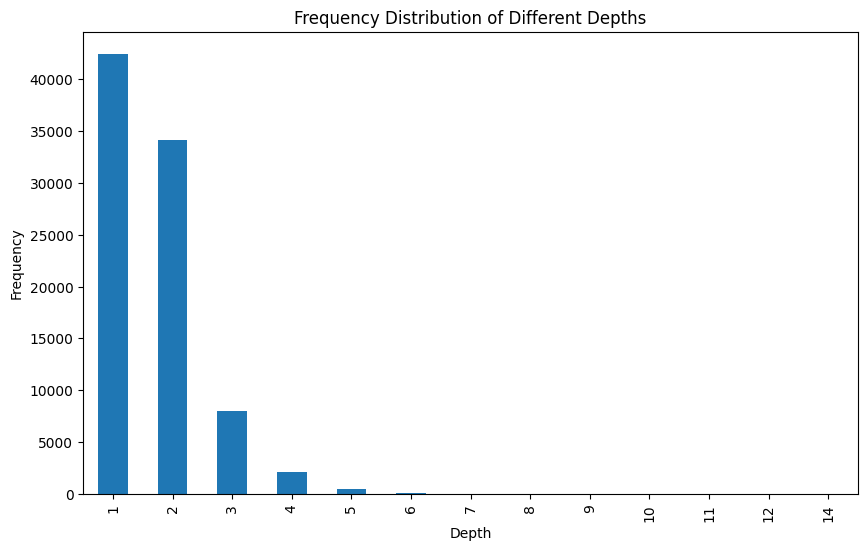

In [ ]:
df_to_plot = pd.DataFrame({'Depth': sorted_depth_freq})

# Plotting Frequency Distribution
plt.figure(figsize=(10, 6))
df_to_plot['Depth'].value_counts().sort_index().plot(kind='bar')
plt.title('Frequency Distribution of Different Depths')
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.show()


todo: parentnode1 , parentnode2 in context column

# Probing 5: Claim Path Density

In [ ]:
def generate_examples(node_df, max_examples=100000):
    drawn_pairs = set()
    examples = []
    discussion_count = 0
    skip_count = 0
    no_valid_start_node_count = 0
    not_enough_depth_levels_count = 0

    with tqdm(total=max_examples, desc="Generating Probe") as example_pbar:
        for _, discussion in node_df.groupby('Base_Claim_ID'):
            discussion_count += 1

            # Initialize counters
            no_valid_start_node_count = 0
            node_reset_count = 0

            unique_depths = discussion['Depth'].unique()
            unique_depths = [depth for depth in unique_depths if depth > 0]

            if len(unique_depths) < 2:
                not_enough_depth_levels_count += 1
                continue

            chosen_start_nodes = set()
            max_depth = discussion['Depth'].max()

            max_attempts = 100  # Set an upper limit on the number of attempts per discussion to avoid getting stuck in infinite loops
            attempt_count = 0  # Initialize a counter to keep track of the number of attempts

            while len(examples) < max_examples:
                if attempt_count > max_attempts:
                    break

                if node_reset_count >= 10:  # avoid infinite loop
                  break

                # Randomly select a depth level less than the max depth
                if max_depth > 2:
                    selected_depth = random.randint(1, max_depth - 1)
                else:
                    selected_depth = 1

                # Get the list of possible start nodes at the randomly selected depth
                possible_start_nodes = discussion.query(f'Depth == {selected_depth} and Node_ID not in @chosen_start_nodes')
                if possible_start_nodes.empty:
                    if node_reset_count < 10:  # Limit the number of resets to 10
                        # Reset the set of chosen start nodes to allow reusing nodes
                        chosen_start_nodes.clear()
                        node_reset_count += 1
                        no_valid_start_node_count += 1
                        continue  # Continue to the next iteration of the loop to reuse nodes
                    else:
                        break  # Exit the loop after 10 resets
                # Shuffle the DataFrame rows
                shuffled_start_nodes = possible_start_nodes.sample(frac=1).reset_index(drop=True)

                # Start from a random claim among the shuffled start nodes
                end_claim_row = shuffled_start_nodes.iloc[0]
                start_claim_row = end_claim_row  # Initialize start claim

                # Add the chosen start node to the set so it won't be chosen again
                chosen_start_nodes.add(start_claim_row['Node_ID'])

                depth_levels_traveled, num_of_claims_below = 0, 0
                visited_nodes = set()

                while start_claim_row['Parent Node'] != 0 and start_claim_row['Depth'] > 1:
                    parent_id = start_claim_row['Parent Node']
                    if parent_id in visited_nodes:
                        break
                    visited_nodes.add(parent_id)

                    try:
                        next_claim_row = discussion[discussion['Node_ID'] == parent_id].iloc[0]
                    except IndexError:
                        break

                    depth_levels_traveled += 1
                    num_of_claims_below += len(start_claim_row['Outgoing_Node_IDs']) if start_claim_row['Outgoing_Node_IDs'] else 0
                    start_claim_row = next_claim_row

                if depth_levels_traveled == 0:  # Skip if no depth levels were traversed
                    skip_count += 1
                    continue

                ratio = num_of_claims_below / depth_levels_traveled
                claim_pair = (start_claim_row['Claim_Text'], end_claim_row['Claim_Text'])

                if claim_pair in drawn_pairs:
                    continue

                drawn_pairs.add(claim_pair)
                examples.append((claim_pair[0], claim_pair[1], ratio))
                example_pbar.update(1)

    print(f"Total Discussions Processed: {discussion_count}")
    print(f"Skipped due to not enough depth levels: {not_enough_depth_levels_count}")
    print(f"Skipped due to no valid start nodes: {no_valid_start_node_count}")
    print(f"Skipped due to zero depth levels traversed: {skip_count}")

    return examples


In [ ]:
generated_examples = generate_examples(node_df)
generated_examples

Generating Probe: 100%|██████████| 100000/100000 [32:24<00:00, 51.42it/s]


Total Discussions Processed: 7407
Skipped due to not enough depth levels: 2855
Skipped due to no valid start nodes: 0
Skipped due to zero depth levels traversed: 218052


[('Cryptocurrencies, such as Bitcoin and others, are beneficial for the world.',
  'Crypto middlemen are less trustworthy than the established banking system.',
  1.75),
 ('Cryptocurrencies, such as Bitcoin and others, are beneficial for the world.',
  'Cryptocurrencies make money laundering much easier.',
  6.0),
 ('Cryptocurrencies, such as Bitcoin and others, are beneficial for the world.',
  'There can be no monetary policy for decentralised digital currencies.',
  4.5),
 ('Cryptocurrencies, such as Bitcoin and others, are beneficial for the world.',
  'People would be incentivised to use cryptocurrencies that do not have this feature to avoid paying extra fees.',
  2.5),
 ('Cryptocurrencies, such as Bitcoin and others, are beneficial for the world.',
  'In order to use Cryptocurrencies without trusting a middleman for your wallet, you have to be very [technically savvy](https://bitcoin.stackexchange.com/questions/23700/can-i-make-and-host-bitcoin-wallet-in-my-own-website-to-get-ri

In [ ]:
save(generated_examples,"depth_frequency_distribution_rnd_c1_100000",4,"list","pkl")

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/4/depth_frequency_distribution_rnd_c1_100000.pkl


In [ ]:
c_p_d_list = load("depth_frequency_distribution_rnd_c1_100000",4,"pkl")

/content/drive/MyDrive/Can Language Models Follow Discussions?/4/depth_frequency_distribution_rnd_c1_100000.pkl loaded.


In [ ]:
len(c_p_d_list)

100000

In [ ]:
def string_label(ratio):
    """Generate a descriptive label based on the ratio."""
    if 0 <= ratio < 0.5:
        return "Sparse"
    elif 0.5 <= ratio < 1.5:
        return "Moderate"
    elif 1.5 <= ratio < 3:
        return "Dense"
    else:
        return "Very Dense"


for 1 claim: nr of outgoint

In [ ]:
def main_function_5(examples, probe_name=""):
    """
    Main function to generate data for probing task 5.
    """
    # Convert examples to DataFrame
    columns = ['Claim1', 'Claim2', 'Label']
    example_df = pd.DataFrame(examples, columns=columns)

    # Reset index for proper alignment
    example_df = example_df.reset_index(drop=True)

    example_df = split_into_folds(example_df)

    # Create a dictionary mapping Claim_Text to Base_Claim_Text using the original DataFrame, and ensure unique keys
    claim_to_base_claim = node_df.drop_duplicates(subset='Claim_Text').set_index('Claim_Text')['Base_Claim_Text'].to_dict()

    # Initialize empty DataFrame with only the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'label', 'string_label']
    final_df = pd.DataFrame(columns=columns_needed)
    # Calculate dynamic thresholds based on distribution
    lower_threshold = np.percentile(example_df['Label'], 25)  # 25th percentile
    middle_threshold = np.percentile(example_df['Label'], 50)  # 50th percentile
    upper_threshold = np.percentile(example_df['Label'], 75)  # 75th percentile

    def dynamic_string_label(ratio):
        if ratio < lower_threshold:
            return "Sparse"
        elif ratio < middle_threshold:
            return "Moderate"
        elif ratio < upper_threshold:
            return "Dense"
        else:
            return "Very Dense"

    #final_df['org_label'] = example_df['Label'].apply(dynamic_string_label)
    # Map string labels to numeric labels
    label_mapping = {"Sparse": 0, "Moderate": 1, "Dense": 2, "Very Dense": 3}

    # Apply dynamic label generation and mapping



    # Fill in the DataFrame
    final_df['index'] = example_df.index + 1  # Index starting from 1
    final_df['id'] = final_df['index']  # 'id' is the same as 'index'
    final_df['inputs'] = example_df.apply(lambda row: (row['Claim1'], row['Claim2']), axis=1)  # Combine both claims
    final_df['context'] = None   # Map Claim1 to its corresponding Base_Claim_Text
    final_df['topic'] = example_df['Claim1'].map(claim_to_base_claim) # Topic is the same as context
    final_df['org_label'] = example_df['Label'].apply(dynamic_string_label)  # Descriptive label
    final_df['string_label'] = final_df['org_label']  # String label is the same as org_label
    final_df['label'] = final_df['org_label'].map(label_mapping)
    #final_df['label'] = example_df['Label']  # Numerical label for regression (harder todo)


    # Transfer the set columns from example_df to final_df
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = example_df[set_column]

    return final_df

# Assuming filtered_level_df is the node_df you mentioned earlier
final_df_5 = main_function_5(c_p_d_list, "probe-5_claim_path_density")
final_df_5

,index,inputs,context,topic,org_label,label,string_label,id,set-0,set-1,set-2,set-3
0,1,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Moderate,1,Moderate,1,test,train,train,dev
1,2,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Very Dense,3,Very Dense,2,dev,test,train,train
2,3,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Very Dense,3,Very Dense,3,train,dev,test,train
3,4,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Dense,2,Dense,4,train,train,dev,test
4,5,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Dense,2,Dense,5,test,train,train,dev
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,(School closures lead to adverse [economic con...,None,NaN,Sparse,0,Sparse,99996,train,train,dev,test
99996,99997,(School closures could lead to widespread soci...,None,Forcing teachers and students back into school...,Very Dense,3,Very Dense,99997,test,train,train,dev
99997,99998,"(Classes can be held online, removing the need...",None,Forcing teachers and students back into school...,Very Dense,3,Very Dense,99998,dev,test,train,train
99998,99999,(School closures could lead to widespread soci...,None,Forcing teachers and students back into school...,Very Dense,3,Very Dense,99999,train,dev,test,train


In [ ]:
save_all_folds_in_one(final_df_5, "claim_path_density", probe_number=5)

After column alignment in save_all_folds_in_one:     index                                             inputs context  \
0      1  (Cryptocurrencies, such as Bitcoin and others,...    None   
1      2  (Cryptocurrencies, such as Bitcoin and others,...    None   
2      3  (Cryptocurrencies, such as Bitcoin and others,...    None   
3      4  (Cryptocurrencies, such as Bitcoin and others,...    None   
4      5  (Cryptocurrencies, such as Bitcoin and others,...    None   

                            topic   org_label  set-0  set-1  set-2  set-3  id  \
0  Anonymous currency discussions    Moderate   test  train  train    dev   1   
1  Anonymous currency discussions  Very Dense    dev   test  train  train   2   
2  Anonymous currency discussions  Very Dense  train    dev   test  train   3   
3  Anonymous currency discussions       Dense  train  train    dev   test   4   
4  Anonymous currency discussions       Dense   test  train  train    dev   5   

  string_label  label  
0     Modera

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Moderate,test,train,train,dev,1,Moderate,1
1,2,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Very Dense,dev,test,train,train,2,Very Dense,3
2,3,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Very Dense,train,dev,test,train,3,Very Dense,3
3,4,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Dense,train,train,dev,test,4,Dense,2
4,5,"(Cryptocurrencies, such as Bitcoin and others,...",None,Anonymous currency discussions,Dense,test,train,train,dev,5,Dense,2
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,(School closures lead to adverse [economic con...,None,NaN,Sparse,train,train,dev,test,99996,Sparse,0
99996,99997,(School closures could lead to widespread soci...,None,Forcing teachers and students back into school...,Very Dense,test,train,train,dev,99997,Very Dense,3
99997,99998,"(Classes can be held online, removing the need...",None,Forcing teachers and students back into school...,Very Dense,dev,test,train,train,99998,Very Dense,3
99998,99999,(School closures could lead to widespread soci...,None,Forcing teachers and students back into school...,Very Dense,train,dev,test,train,99999,Very Dense,3


In [ ]:
shuffled_values = final_df_5.values
np.random.shuffle(shuffled_values)
final_df_5_shuffled = pd.DataFrame(shuffled_values, columns=final_df_5.columns)
final_df_5_shuffled.head(10)

,index,inputs,context,topic,org_label,label,string_label,id,set-0,set-1,set-2,set-3
0,56537,(The Bible does not support the conclusion tha...,None,Should same-sex marriage be legalised in Austr...,Dense,2.0,Dense,56537,test,train,train,dev
1,64821,(Abusive people are likely to change their beh...,None,People should break up with their partner at t...,Dense,2.2,Dense,64821,test,train,train,dev
2,79868,(Some rights are too fundamental and important...,None,"In countering terrorism, the state should neve...",Dense,2.0,Dense,79868,train,train,dev,test
3,13391,([Negative](https://en.wikipedia.org/wiki/Nega...,None,What [religion](https://en.wikipedia.org/wiki/...,Very Dense,5.0,Very Dense,13391,train,dev,test,train
4,83283,(There's no verifiable evidence for the existe...,None,A divine being created the universe.,Dense,2.0,Dense,83283,train,dev,test,train
5,67636,"(Jesus was birthed from Mary, a woman., In [So...",None,Jesus was a divine being.,Dense,2.75,Dense,67636,train,train,dev,test
6,18458,(It might be a valuable experience to have sex...,None,It's always immoral to sleep with a married pe...,Moderate,1.0,Moderate,18458,dev,test,train,train
7,91893,(If fake news is made illegal the government w...,None,Fake news should be illegal.,Moderate,1.0,Moderate,91893,test,train,train,dev
8,87322,(Freedom of sexuality is a means of reaching s...,None,Freedom of sexuality is inducing harm.,Very Dense,3.0,Very Dense,87322,dev,test,train,train
9,78608,"(Children don't decide to be born., Not opting...",None,A child doesn't owe his parents something for ...,Moderate,1.0,Moderate,78608,train,train,dev,test


# Post Process Links of folds.csv claim inputs

In [ ]:
def process_links(text, remove_https_only=True):
    pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urls = re.findall(pattern, text)

    processed_text = text
    for url in urls:
        if remove_https_only:
            # Keep only the main part of the URL, excluding 'https://'
            main_part = url.split('//')[-1].split('/')[0]
            processed_text = processed_text.replace(url, main_part)
        else:
            # Process the URL to keep the main part in a formatted way
            main_part = url.split('www.')[-1].split('.')[0]
            reference = f"see website ({main_part})"
            processed_text = processed_text.replace(url, reference)

    return processed_text


def parse_tuple(x):
    try:
        return ast.literal_eval(x)
    except:
        return ()

def process_fold_csv(file_path, remove_https_only=True):
    try:
        df = pd.read_csv(file_path)
        df['inputs'] = df['inputs'].apply(lambda x: tuple(process_links(input_text, remove_https_only) for input_text in parse_tuple(x)))
        df.to_csv(file_path, index=False)
        print("Succesfully processed and saved to ", file_path)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

def process_all_folds(base_path, remove_https_only=True):
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('folds.csv'):
                    file_path = os.path.join(folder_path, file)
                    process_fold_csv(file_path, remove_https_only)

def process_and_save_node_df(node_df, save_path, remove_https_only=True):
    node_df['Claim_Text'] = node_df['Claim_Text'].fillna('').astype(str).apply(lambda x: process_links(x, remove_https_only))
    node_df['Claim_Text'].replace('', None, inplace=True)
    with open(save_path, 'wb') as f:
        pickle.dump(node_df, f)
        print("Succesfully processed and saved to ", save_path)



base_path_gdrive_probing = "/content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files"
#node_df_path = "/content/drive/MyDrive/Can Language Models Follow Discussions?//2/node_attributes_v6.pkl"
save_path =  "/content/drive/MyDrive/Can Language Models Follow Discussions?//2/node_attributes_v7.pkl"

process_all_folds(base_path_gdrive_probing, remove_https_only=True)
process_and_save_node_df(node_df, save_path, remove_https_only=True)

Succesfully processed and saved to  /content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_4-different_depths/folds.csv
Succesfully processed and saved to  /content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_3-reactiveness/folds.csv
Succesfully processed and saved to  /content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_1_subsampled-affirming_opposing/folds.csv
Succesfully processed and saved to  /content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_2-sequential claims/folds.csv
Succesfully processed and saved to  /content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_5-claim_path_density_cat_labels/folds.csv
Succesfully processed and saved to  /content/drive/MyDrive/Can Language Models Follow Discussions?/probing_files/probe_5-claim_path_density_regr_labels/folds.csv
Succesfully processed and saved to  /content/drive/MyDrive/Can Language Mod

In [ ]:
node_df["Claim_Text"][node_df["Claim_Text"].str.contains("website") == True]

13                                                                                                                                                                                                                                                                                         Cryptocurrency mining consumes a lot of [energy](see website (theguardian)
15                                                                                                                                                                                                                                                                                          Cryptocurrency mining requires a lot of [hardware](see website (coindesk)
20        Technologies like [IOTA](see website (iota) herald the emergence of "[Machine Economy](see website (innovationhub)" - machines capable of earning and spending money on their own by trading resources such as data, computing power, storage or physical services to other machin

In [ ]:
def remove_unclosed_bracket(text):
    # Pattern to find "(see website"
    pattern = r'\(see website'

    # Replace "(see website" with "see website" (remove the opening bracket)
    processed_text = re.sub(pattern, 'see website', text)

    return processed_text

def process_and_save_node_df(node_df, save_path):
    # Apply the remove_unclosed_bracket function to the 'Claim_Text' column
    node_df['Claim_Text'] = node_df['Claim_Text'].fillna('').astype(str).apply(remove_unclosed_bracket)

    # Convert empty strings back to None (NaN)
    node_df['Claim_Text'].replace('', None, inplace=True)

    # Save the processed DataFrame
    with open(save_path, 'wb') as f:
        pickle.dump(node_df, f)

def process_all_folds(base_path):
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('folds.csv'):
                    file_path = os.path.join(folder_path, file)
                    process_fold_csv(file_path)

def process_fold_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        df['inputs'] = df['inputs'].apply(lambda x: tuple(remove_unclosed_bracket(input_text) for input_text in parse_tuple(x)))
        df.to_csv(file_path, index=False)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Example usage
base_path_gdrive = "/path/to/your/folds"
node_df_path = "/path/to/your/node_df.pkl"
save_path = "/path/to/save/processed_node_df.pkl"

# Process all folds and the node_df
process_all_folds(base_path_gdrive)
process_and_save_node_df(node_df, save_path)
